In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm, colors
import glob

from numba import njit, vectorize, float32

from typing import Callable, Optional, Union

import hoomd
import gsd.hoomd
import freud

import sys
import time
import pickle
import gc
import warnings
import copy
import pathlib

import os
import sys

import signac
import tqdm
import scipy.signal

from dataclasses import dataclass
from dataclasses_json import dataclass_json

In [2]:
from monk import nb, prep, pair, render, utils, workflow, methods, grid
# render.preview_tracer.resize(800, 800)

parent = pathlib.Path(os.getcwd()).parent / "config.yaml"
config = workflow.get_config(parent.as_posix())

In [3]:
project: signac.Project = signac.get_project(root=config['root'])

In [4]:
from copy import deepcopy

class ArrayVariant(hoomd.variant.Variant):
    def __init__(self, array):
        self.array = array
        self.__min = np.min(array)
        self.__max = np.max(array)
        self.idx = 0
        hoomd.variant.Variant.__init__(self)

    def __call__(self, timestep):
        if self.idx < len(self.array):
            result = self.array[self.idx]
            self.idx += 1
            return result
        else:
            return self.array[-1]

    def _min(self):
        return self.__min

    def _max(self):
        return self.__max

class SnapCut:

    def __init__(self, snapshot: gsd.hoomd.Snapshot, query_index, r_free=2.0, r_hard=2.5, angles=None):
        if angles is None:
            self.angles = np.linspace(0.0, 180.0, 180, endpoint=False)
        else:
            self.angles = angles
        self.snap = snapshot
        self.dim = snapshot.configuration.dimensions
        assert self.dim == 2
        self.r_free = r_free
        self.r_hard = r_hard

        r_max = r_free + r_hard
        # sep = 2.0*r_max + r_hard
        nlist_query = freud.locality.AABBQuery.from_system(snapshot)
        query_pos = snapshot.particles.position[query_index]
        if len(query_pos.shape) < 2:
            query_pos = query_pos[np.newaxis, :]
        nlist = nlist_query.query(query_pos, {'r_max': r_max}).toNeighborList()

        box = freud.box.Box.from_box(snapshot.configuration.box)

        size = np.sum(nlist.neighbor_counts)
        pos = np.zeros((size, 3))
        typeid = np.zeros(size, dtype=np.int32)
        diameters = np.zeros(size)
        include = np.ravel(np.argwhere(nlist.distances < r_free)).astype(np.uint32)
        exclude = np.ravel(np.argwhere(nlist.distances >= r_free)).astype(np.uint32)
        i = 0
        j = 0
        for head, nn in zip(nlist.segments, nlist.neighbor_counts):
            indices = nlist.point_indices[head:head+nn]
            pos[j:j+nn] = box.wrap(snapshot.particles.position[indices] - query_pos[i])
            typeid[j:j+nn] = snapshot.particles.typeid[indices]
            diameters[j:j+nn] = snapshot.particles.diameter[indices]
            i += 1
            j += nn

        self.pos = pos
        self.nlist = nlist
        self.typeid = typeid
        self.diameters = diameters
        self.include = include
        self.exclude = exclude

    def to_snap(self, index=0, theta=0.0, degrees=True):
        snap = gsd.hoomd.Snapshot()
        head = self.nlist.segments[index]
        nn = self.nlist.neighbor_counts[index]

        Lz = 4.0*self.r_free
        if self.dim == 2:
            Lz = 0

        if degrees:
            theta = np.deg2rad(theta)
        rot = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])

        snap.configuration.dimensions = self.dim
        snap.configuration.box = [4.0*self.r_free + self.r_hard, 4.0*self.r_free + self.r_hard, 0, 0, 0, 0]

        snap.particles.N = nn
        tmp = self.pos[head:head+nn]
        tmp[:,:2] = np.dot(rot, tmp[:,:2].T).T
        snap.particles.position = tmp
        snap.particles.typeid = self.typeid[head:head+nn]
        snap.particles.diameter = self.diameters[head:head+nn]
        snap.particles.types = self.snap.particles.types
        return snap

    def run_local_strain_test(self, index=0, report=False):
        sim = hoomd.Simulation(hoomd.device.CPU(), seed=0)
        snap = hoomd.Snapshot.from_gsd_snapshot(self.to_snap(index), sim.device.communicator)
        head = self.nlist.segments[index]
        nn = self.nlist.neighbor_counts[index]
        try:
            sim.create_state_from_snapshot(snap)
        except:
            sim.state.set_snapshot(snap)

        include = self.include[head:head+nn]
        # exclude = self.exclude[head:head+nn]

        tree = hoomd.md.nlist.Tree(0.3)
        # hertz = pair.bi_hertz(tree)
        kalj = pair.KA_LJ(tree)
        nve = hoomd.md.methods.NVE(filter=hoomd.filter.Tags(include))
        fire = hoomd.md.minimize.FIRE(1e-2, 1e-2, 1.0, 1e-5)
        fire.forces = [kalj]
        fire.methods = [nve]
        sim.operations.integrator = fire
        sim.run(0)

        # writer = hoomd.write.GSD(filename='test.gsd', trigger=hoomd.trigger.Periodic(10000, 999), mode='wb')
        # sim.operations.writers.append(writer)

        virials = []

        ramp = np.linspace(0, 1, 81)
        len_ramp = len(ramp)

        # angles = np.linspace(0.0, 175.0, 36)
        angles = self.angles
        idx = 0

        if report:
            iter = tqdm.tqdm(angles)
        else:
            iter = angles
        
        for theta in iter:
            # print(f"[{idx}/{len(angles)}]:", theta)
            snap = hoomd.Snapshot.from_gsd_snapshot(self.to_snap(index, theta), sim.device.communicator)
            sim.state.set_snapshot(snap)
            box = sim.state.box
            new_box = deepcopy(box)
            new_box.xy = 0.40
            trigger = methods.AsyncTrigger()
            variant = ArrayVariant(ramp)
            updater = hoomd.update.BoxResize(trigger, box, new_box, variant)
            sim.operations.updaters.append(updater)

            virial_run = np.zeros((len_ramp, 3))
            
            for i in range(len_ramp):
                
                fire.reset()
                while not fire.converged:
                    sim.run(1000)
                sim.always_compute_pressure = True
                sim.run(0)
                virial_run[i] = np.mean(kalj.virials[include][: ,[0,1,3]], axis=0)
                sim.always_compute_pressure = False
                if i < len_ramp - 1:
                    trigger.activate()
                sim.run(0)
            sim.operations.updaters.remove(updater)
            virials.append(virial_run)
            idx += 1
            
        return np.array(virials), angles


In [5]:
for job in project.find_jobs({"prep": "ESL"}):
    break

In [26]:
for job in project.find_jobs({"prep": "ESL"}):
    print(job)
    files = glob.glob(job.fn("experiments/max-shear-*/*/traj-fire_period-1000.0.gsd"))
    soft_df = pd.read_parquet(files[-1].replace("traj-fire_period-1000.0.gsd", "strob-softness_period-1000.0.parquet"), engine="pyarrow")
    traj = gsd.hoomd.open(files[-1])
    snap = traj[-1]
    M = 9
    snapcut = SnapCut(snap, 0, r_free=5.0, r_hard=3.0, angles=np.linspace(-45.0, 45.0, M, endpoint=False))
    virials, angles = snapcut.run_local_strain_test(0)
    np.save(job.fn('virials.npy'), virials)
    np.save(job.fn('angles.npy'), angles)
    # print(job)
    # print(virials.shape, angles.shape)
    # print(virials)
    # print(angles)
    break

7ec2f6aca035e69077eab24383a21cb6


Text(0.5, 0, '$\\gamma_{xy}$')

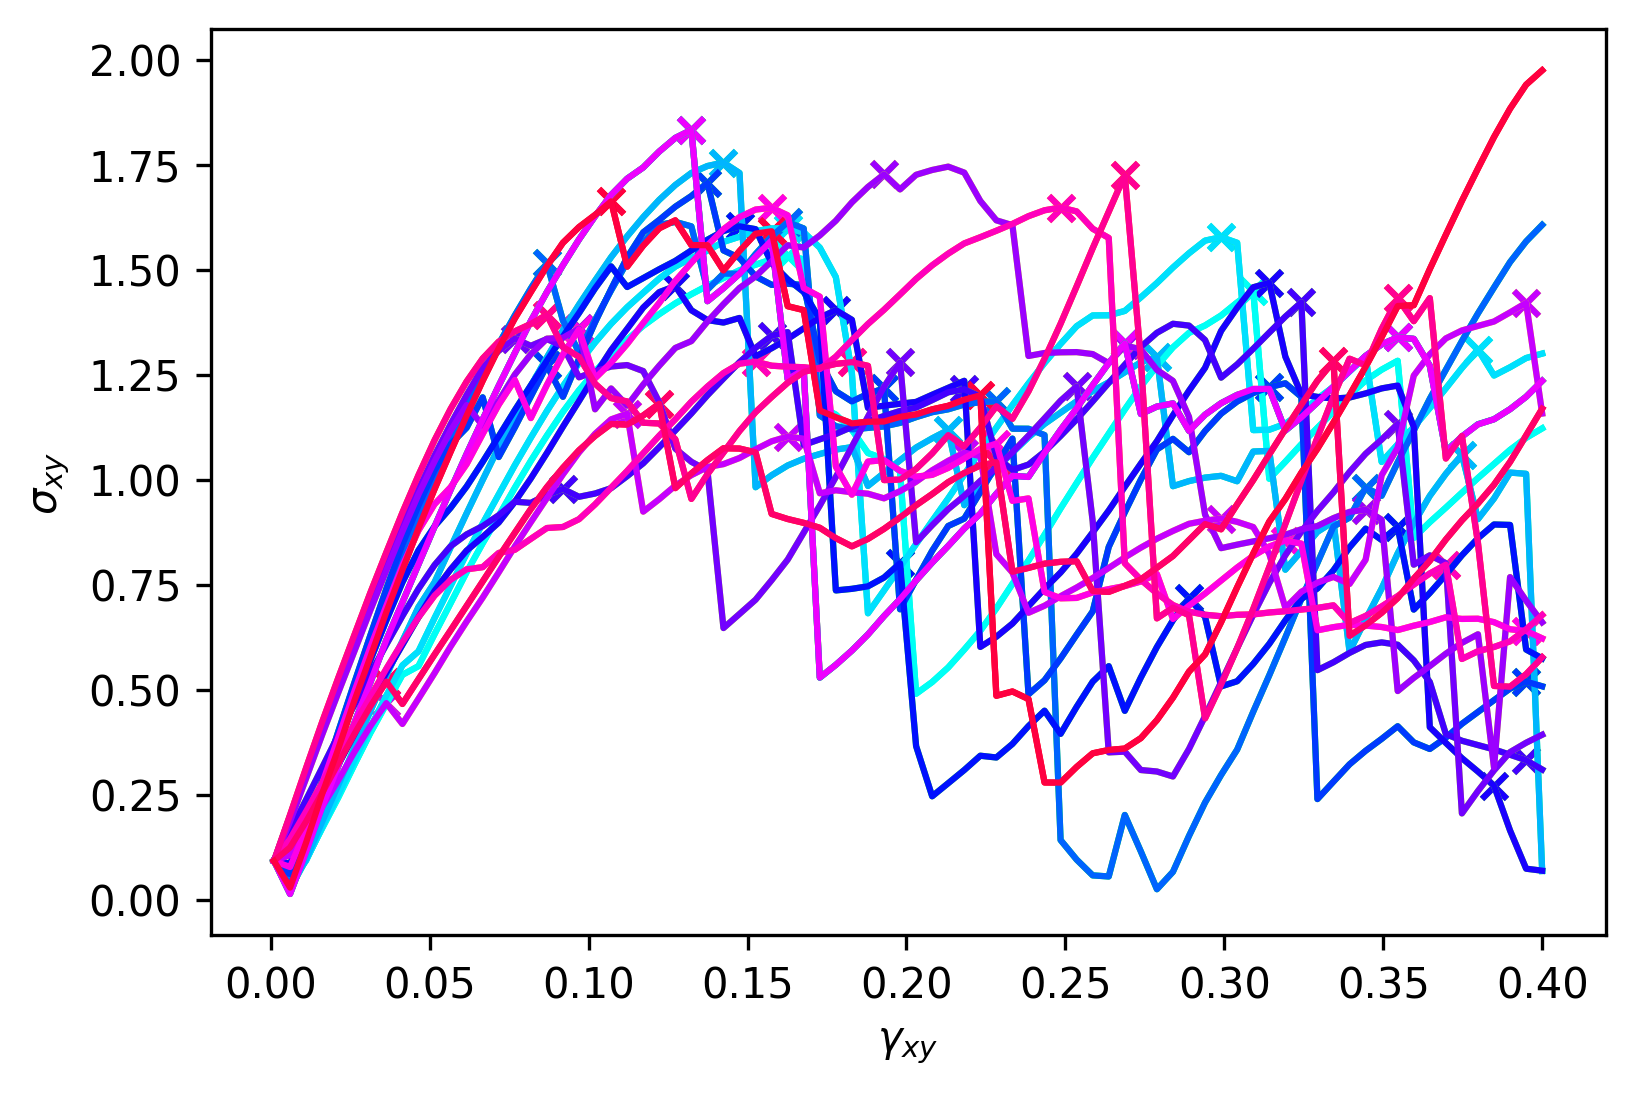

In [27]:
cmap = cm.hsv
norm = mpl.colors.Normalize(vmin=0, vmax=M)

plt.figure(dpi=150)

strain = np.linspace(0.001, .4, 80)

for i in range(len(angles)):
    
    peaks = scipy.signal.find_peaks(-virials[i,1:,1], distance=10)[0]
    # print(len(peaks))
    xy = -virials[i,1:,1]
    yy = virials[i,1:,2]
    xx = virials[i,1:,0]
    dxy = (xx - yy) / 2
    mag = np.sqrt(dxy**2 + xy**2)
    plt.plot(strain, mag, color=cmap(norm(i)));
    plt.scatter(strain[peaks], mag[peaks], color=cmap(norm(i)), marker='x')
plt.ylabel(r'$\sigma_{xy}$')
plt.xlabel(r'$\gamma_{xy}$')
# plt.title(f'r_free = {cut:.1f}')

-45.0
-42.5
-40.0
-37.5
-35.0
-32.5
-30.0
-27.5
-25.0
-22.5
-20.0
-17.5
-15.0
-12.5
-10.0
-7.5
-5.0
-2.5
0.0
2.5
5.0
7.5
10.0
12.5
15.0
17.5
20.0
22.5
25.0
27.5
30.0
32.5
35.0
37.5
40.0
42.5


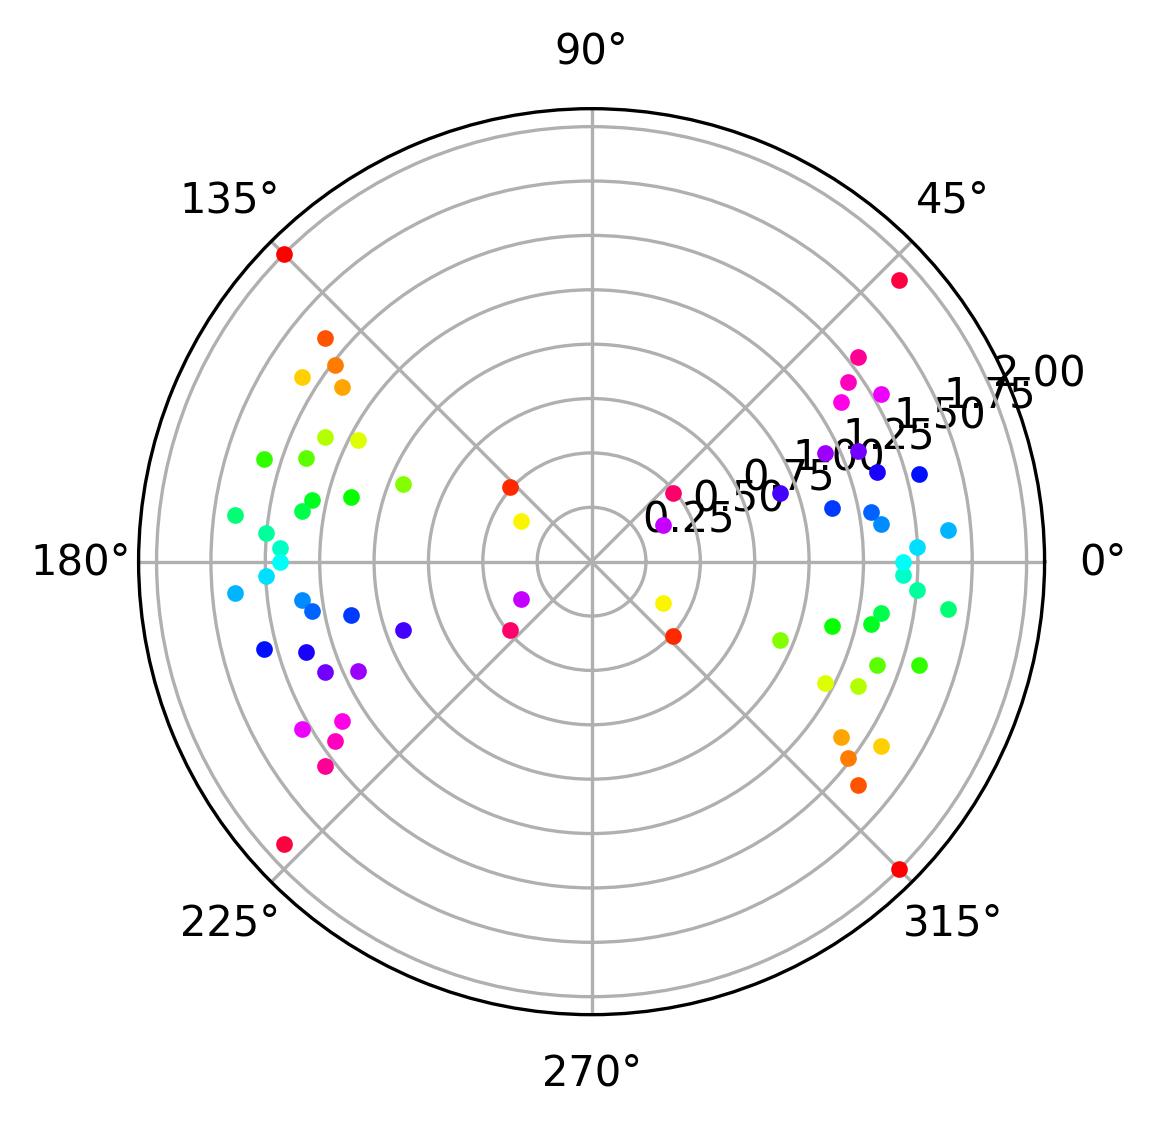

In [29]:
cmap = cm.hsv
# M = 36
norm = mpl.colors.Normalize(vmin=0, vmax=M)

strain = np.linspace(0, 0.4, 101)

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, dpi=150, figsize=(4,4))

yield_strains = []
yield_stresses = []
yield_angles = []

for i in range(len(angles)):
    print(angles[i])
    # cond = np.diff(virials[i,1:,1], axis=0) > 1e-3
    # y = strain[cond]
    peaks = scipy.signal.find_peaks(-virials[i,:,1], distance=10)[0]
    if len(peaks) == 0:
        # print("yo!")
        y = [0.1]
        plt.plot(i/M*np.pi*np.ones_like(y), y, "x", color="k");
        plt.plot((i+M)/M*np.pi*np.ones_like(y), y, "x", color="k");
        continue
    # print(peaks)
    # y = strain[peaks[0]]
    xy = -virials[i,1:,1]
    yy = virials[i,1:,2]
    xx = virials[i,1:,0]
    dxy = (xx - yy) / 2
    mag = np.sqrt(dxy**2 + xy**2)
    a = angles[i]
    y = (mag[peaks[0]] - mag[0])/np.cos(a*np.pi/180)
    yield_strains.append(y)
    yield_stresses.append(-virials[i,peaks[0],1])
    yield_angles.append(angles[i])
    x = a*np.pi/180
    x2 = x + np.pi
    plt.plot(x, y, ".", color=cmap(norm(i)));
    plt.plot(x2, y, ".", color=cmap(norm(i)));
# plt.yscale('log')
# plt.ylim(1e-9, 1e-2)

(array([2.1011976 , 0.        , 0.        , 0.        , 0.        ,
        0.84047904, 0.84047904, 1.68095808, 0.        , 2.1011976 ]),
 array([0.4080336 , 0.54023335, 0.67243309, 0.80463283, 0.93683257,
        1.06903231, 1.20123205, 1.33343179, 1.46563153, 1.59783127,
        1.73003101]),
 <BarContainer object of 10 artists>)

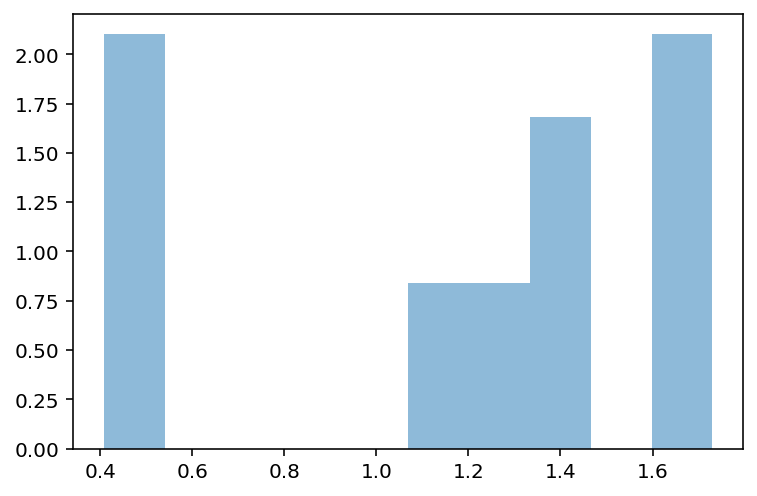

In [14]:
plt.hist(yield_strains, bins=10, density=True, alpha=0.5)

(array([2.34229448, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.93691779, 0.93691779, 1.87383558, 2.34229448]),
 array([0.44052297, 0.55911513, 0.6777073 , 0.79629947, 0.91489163,
        1.0334838 , 1.15207597, 1.27066813, 1.3892603 , 1.50785247,
        1.62644464]),
 <BarContainer object of 10 artists>)

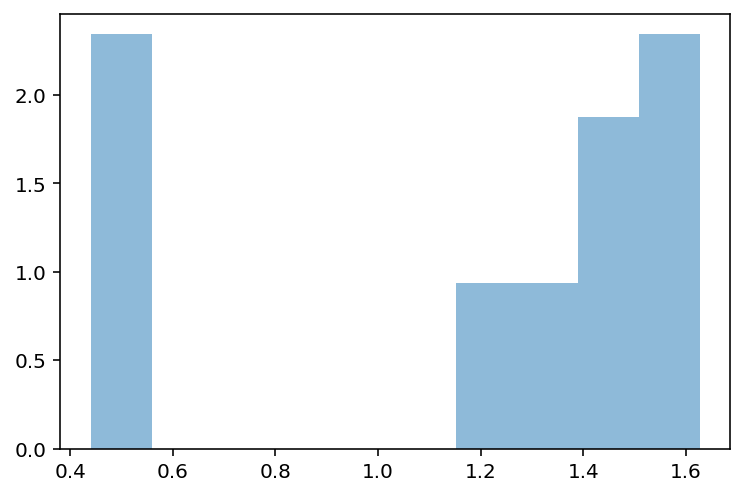

In [15]:
plt.hist(yield_stresses, bins=10, density=True, alpha=0.5)

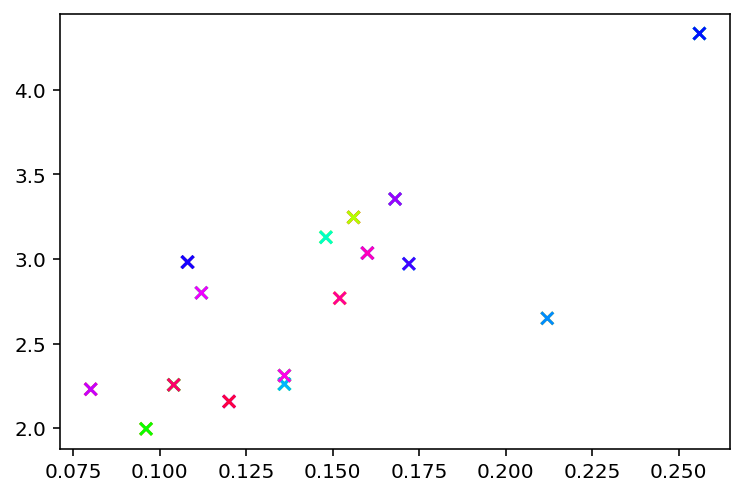

In [177]:
cmap = cm.hsv
norm = mpl.colors.Normalize(vmin=0, vmax=180)
plt.scatter(yield_strains, yield_stresses, color=cmap(norm(yield_angles)), marker='x')

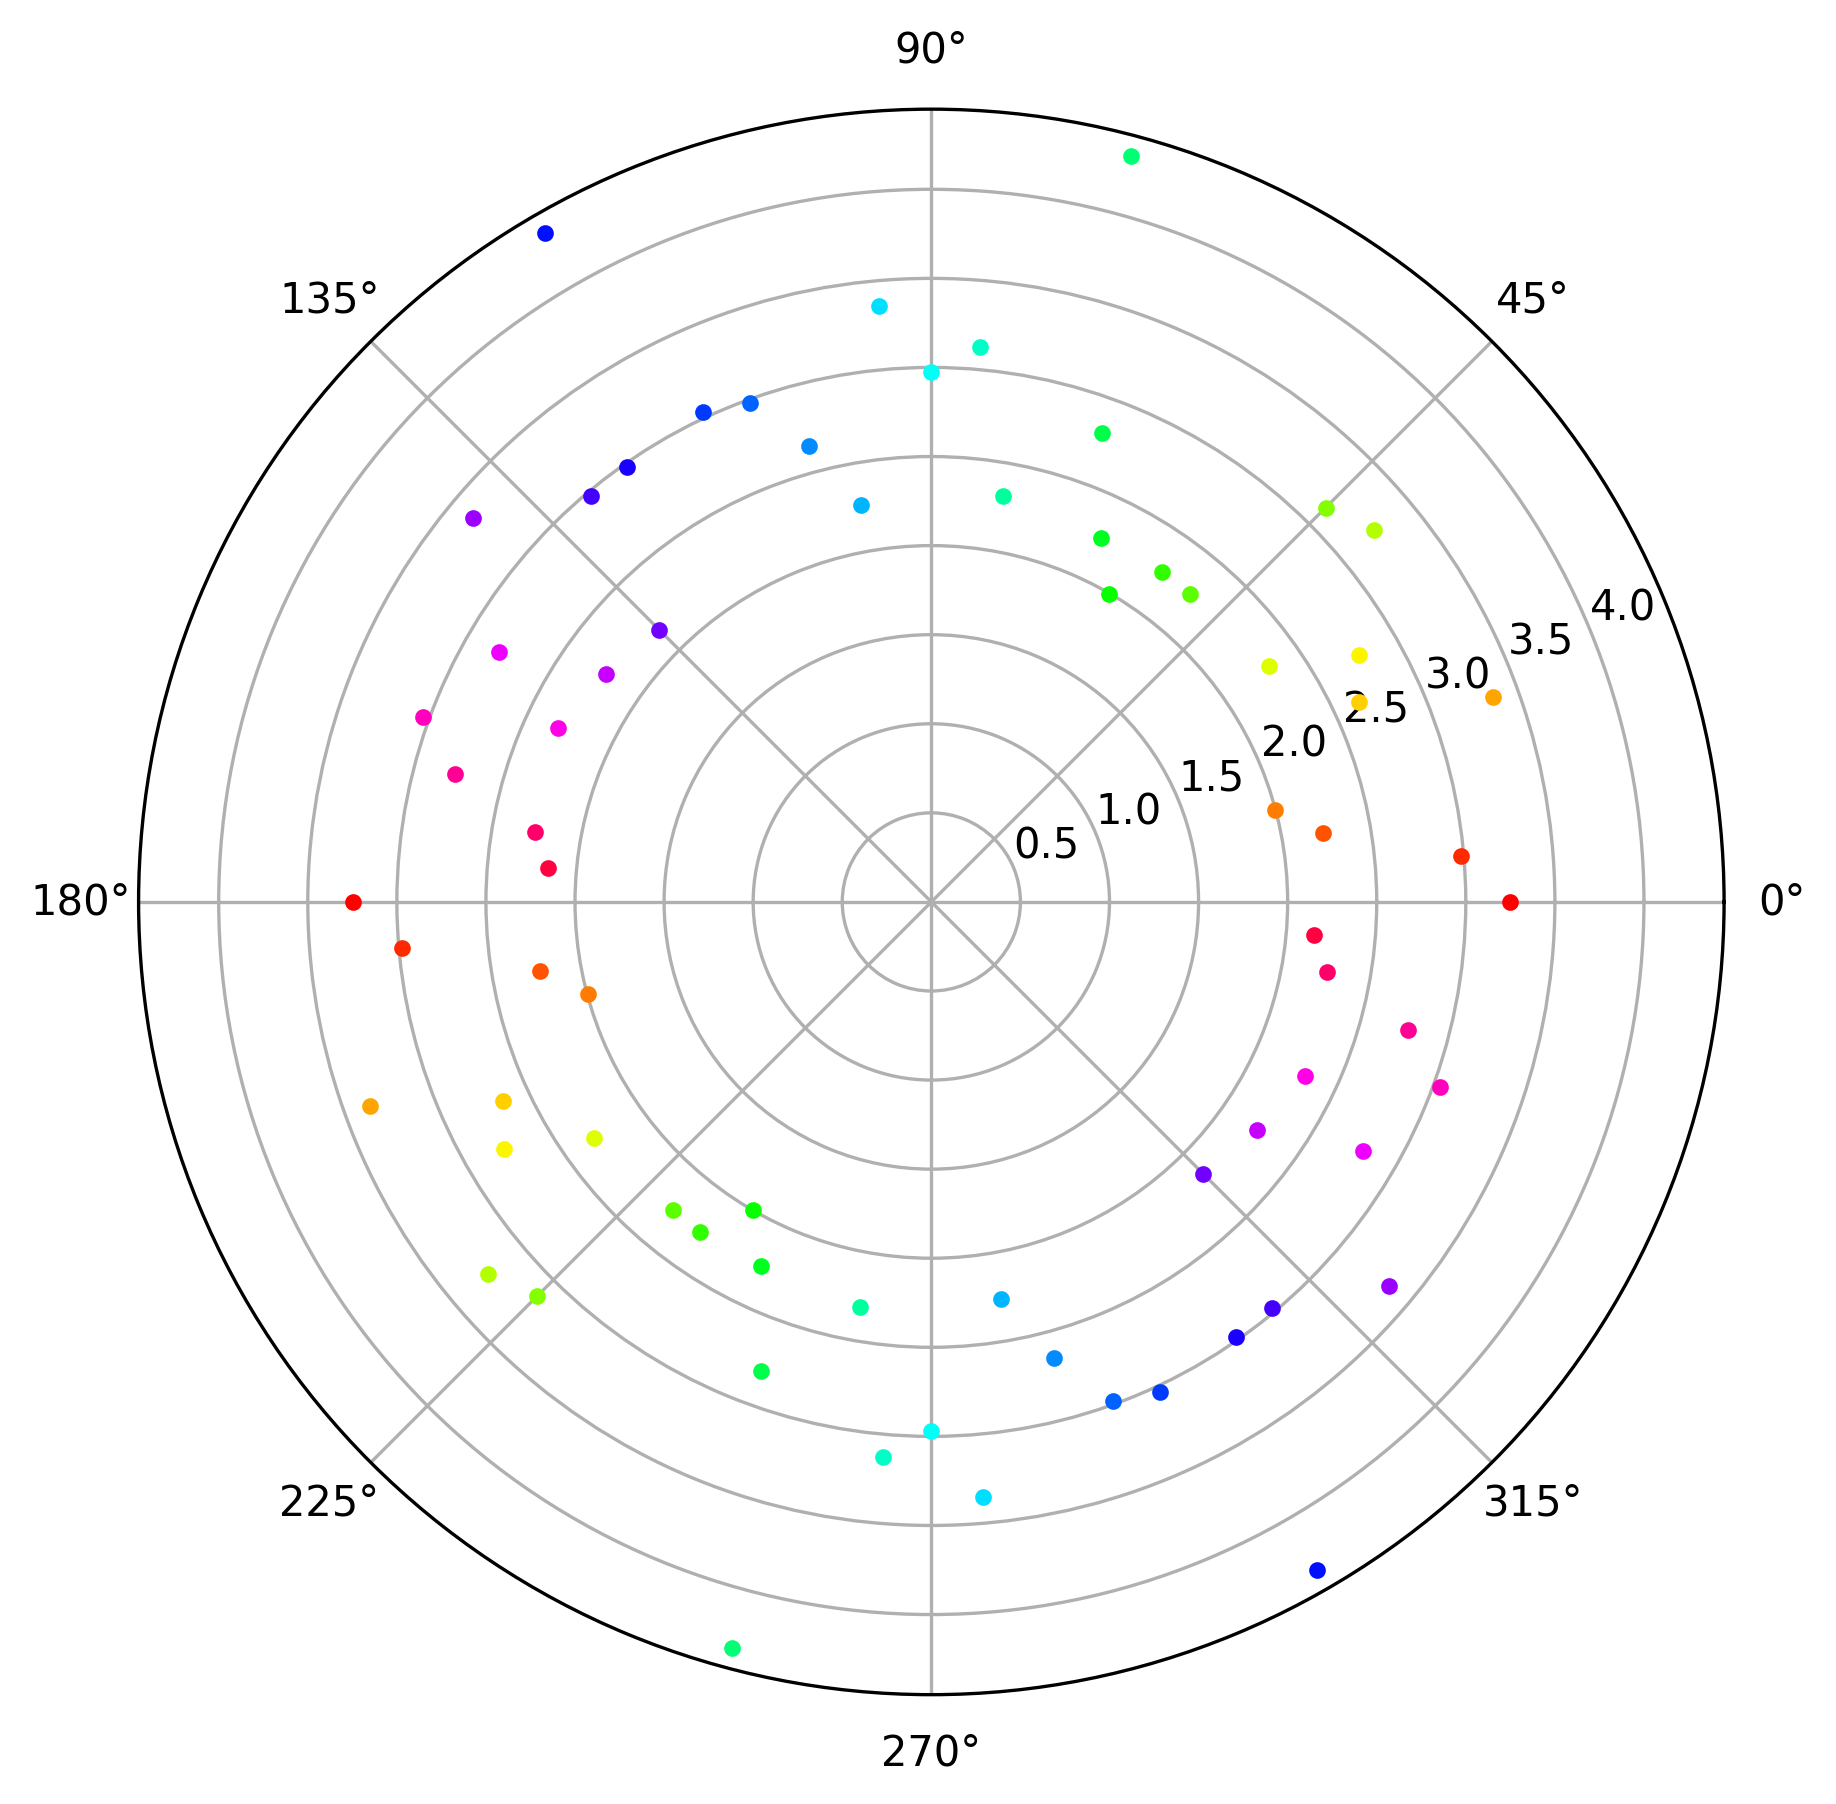

In [178]:
cmap = cm.hsv
# M = 179
norm = mpl.colors.Normalize(vmin=0, vmax=M)

strain = np.linspace(0, 0.4, 101)

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, dpi=150, figsize=(7,7))

# yield_strains = []
# yield_stresses = []
# yield_angles = []

for i in range(len(angles)):
    # cond = np.diff(virials[i,1:,1], axis=0) > 1e-3
    # y = strain[cond]
    peaks = scipy.signal.find_peaks(-virials[i,:,1], distance=10)[0]
    if len(peaks) == 0:
        y = [0.1]
        plt.plot(i/M*np.pi*np.ones_like(y), y, "x", color="k");
        plt.plot((i+M)/M*np.pi*np.ones_like(y), y, "x", color="k");
        continue
    # y = strain[peaks[0]]
    y = -virials[i,peaks[0],1]
    # yield_strains.append(y)
    # yield_stresses.append(-virials[i,peaks[0],1])
    # yield_angles.append(angles[i])

    plt.plot(i/M*np.pi*np.ones_like(y), y, ".", color=cmap(norm(i)));
    plt.plot((i+M)/M*np.pi*np.ones_like(y), y, ".", color=cmap(norm(i)));
# plt.yscale('log')
# plt.ylim(1e-9, 1e-2)

In [7]:
# for job in project.find_jobs({"prep": "ESL"}):
for job in [project.open_job(id="a8f2c249ed85533b56b0729b7ab96d18")]:
    print(job)
    files = glob.glob(job.fn("longer_experiments/max-shear-0.04/temp-1.9836e-02/traj-fire_period-1000.0.gsd"))
    soft_df = pd.read_parquet(files[-1].replace("traj-fire_period-1000.0.gsd", "strob-softness_period-1000.0.parquet"), engine="pyarrow")
    traj = gsd.hoomd.open(files[-1])
    snap = traj[-1]
    M = 18
    N = len(snap.particles.position)
    strains = np.linspace(0, 0.4, 81)
    softness = soft_df.iloc[-1]["soft"]
    out_soft = []
    out_stress = []
    out_strain = []
    # print("hi")
    print(N)
    for i in tqdm.tqdm(np.arange(0, N, 100)):
        # print(i)
        soft = softness[i]
        snapcut = SnapCut(snap, i, r_free=5.0, r_hard=3.0, angles=np.linspace(0.0, 180.0, M, endpoint=False))
        virials, angles = snapcut.run_local_strain_test(0, report=False)
        ss = []
        ys = []
        for j in range(len(angles)):
            peaks = scipy.signal.find_peaks(-virials[j,:,1], distance=10)[0]
            if len(peaks) != 0:
                y = -virials[j,peaks[0]]
                s = strains[peaks[0]]
                ss.append(s)
                ys.append(y)

        out_soft.append(soft)
        out_stress.append(np.array(ys))
        out_strain.append(np.array(ss))


    np.savez(job.fn('yield-100-rcut5.npz'), soft=out_soft, stress=out_stress, strain=out_strain)
    # np.save(job.fn('virials.npy'), virials)
    # np.save(job.fn('angles.npy'), angles)
    # # print(job)
    # # print(virials.shape, angles.shape)
    # # print(virials)
    # # print(angles)
    break

a8f2c249ed85533b56b0729b7ab96d18
32768


  0%|          | 1/328 [00:11<1:05:20, 11.99s/it]

In [5]:
# for htl_job in project.find_jobs({"prep": "HTL"}):
for htl_job in [project.open_job(id="ecce68c50e28a33684826f28780bf6e9")]:
    print(htl_job)
    files = glob.glob(htl_job.fn("longer_experiments/max-shear-0.04/temp-1.9836e-02/traj-fire_period-1000.0.gsd"))
    soft_df = pd.read_parquet(files[-1].replace("traj-fire_period-1000.0.gsd", "strob-softness_period-1000.0.parquet"), engine="pyarrow")
    traj = gsd.hoomd.open(files[-1])
    snap = traj[-1]
    M = 18
    N = len(snap.particles.position)
    strains = np.linspace(0, 0.4, 81)
    softness = soft_df.iloc[-1]["soft"]
    out_soft = []
    out_stress = []
    out_strain = []
    # print("hi")
    print(N)
    for i in tqdm.tqdm(np.arange(0, N, 100)):
        # print(i)
        soft = softness[i]
        snapcut = SnapCut(snap, i, r_free=5.0, r_hard=3.0, angles=np.linspace(0.0, 180.0, M, endpoint=False))
        virials, angles = snapcut.run_local_strain_test(0, report=False)
        ss = []
        ys = []
        for j in range(len(angles)):
            peaks = scipy.signal.find_peaks(-virials[j,:,1], distance=10)[0]
            if len(peaks) != 0:
                y = -virials[j,peaks[0]]
                s = strains[peaks[0]]
                ss.append(s)
                ys.append(y)

        out_soft.append(soft)
        out_stress.append(np.array(ys))
        out_strain.append(np.array(ss))


    np.savez(htl_job.fn('yield-100-rcut5.npz'), soft=out_soft, stress=out_stress, strain=out_strain)
    # np.save(job.fn('virials.npy'), virials)
    # np.save(job.fn('angles.npy'), angles)
    # # print(job)
    # # print(virials.shape, angles.shape)
    # # print(virials)
    # # print(angles)
    
    break

ecce68c50e28a33684826f28780bf6e9
32768


 44%|████▍     | 144/328 [27:53<35:41, 11.64s/it] 

In [4]:
job = project.open_job(id="a8f2c249ed85533b56b0729b7ab96d18")
htl_job = project.open_job(id="ecce68c50e28a33684826f28780bf6e9")

In [5]:
htl_output = np.load(htl_job.fn('yield-10.npz'), allow_pickle=True)

In [6]:
output = np.load(job.fn('yield-10.npz'), allow_pickle=True)

In [7]:
zoft = np.load("../notebooks/yieldstress-data.npz")

(array([ 67., 301., 723., 894., 700., 391., 137.,  46.,  16.,   2.]),
 array([-1.64154685, -1.25954103, -0.8775351 , -0.49552923, -0.11352336,
         0.26848251,  0.65048838,  1.03249431,  1.41450012,  1.79650593,
         2.17851186]),
 <BarContainer object of 10 artists>)

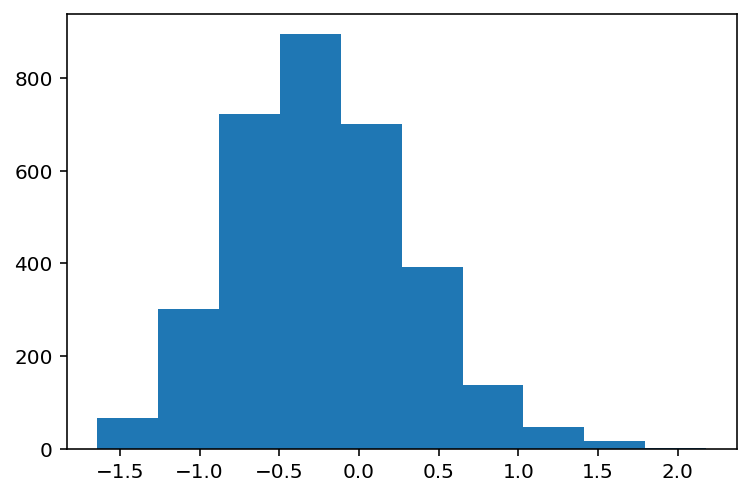

In [8]:
# plt.hist(output["soft"])

In [88]:
func = np.min

stress = []
out_stress = output["stress"]
for i in range(len(out_stress)):
    t = out_stress[i]
    d = (t[:,0]-t[:,2])/2
    s = t[:,1]
    x = d*d + s*s
    xmean = func(x)
    stress.append(xmean)

htl_stress = []
out_stress = htl_output["stress"]
for i in range(len(out_stress)):
    t = out_stress[i]
    d = (t[:,0]-t[:,2])/2
    s = t[:,1]
    x = d*d + s*s
    xmean = func(x)
    htl_stress.append(xmean)

# plt.hist(htl_stress, bins=10, density=True, alpha=0.5)

# plt.hist(stress, bins=10, density=True, alpha=0.5)

In [89]:
strain = []
out_strain = output["strain"]
for i in range(len(out_stress)):
    t = out_strain[i]
    xmean = func(t)
    strain.append(xmean)

htl_strain = []
out_strain = htl_output["strain"]
for i in range(len(out_stress)):
    t = out_strain[i]
    xmean = func(t)
    htl_strain.append(xmean)

# plt.hist(stress, bins=10, density=True, alpha=0.5)

In [90]:
import seaborn as sns

Text(0, 0.5, '$|\\sigma^Y_{dev}|$')

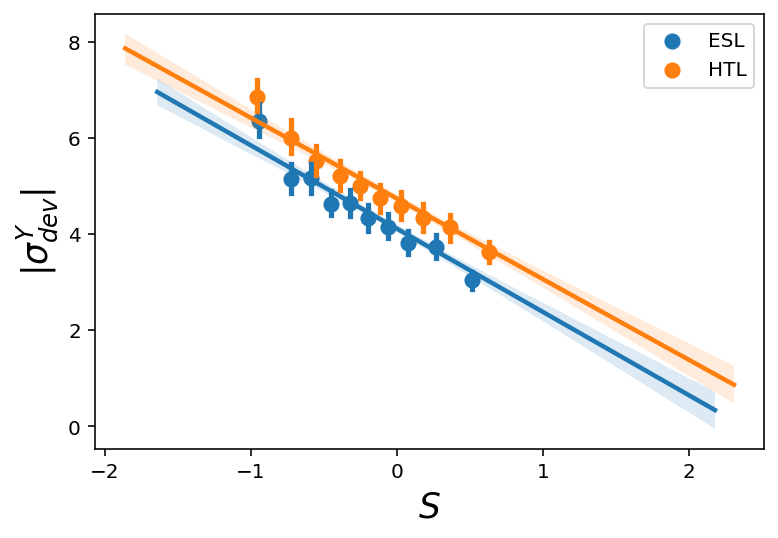

In [91]:
sns.regplot(x=output["soft"], y=stress, x_bins=10, label="ESL")
sns.regplot(x=htl_output["soft"], y=htl_stress, x_bins=10, label="HTL")
plt.legend()
plt.xlabel(r"$S$", size="xx-large")
plt.ylabel(r"$|\sigma^Y_{dev}|$", size="xx-large")

Text(0, 0.5, '$\\gamma^Y$')

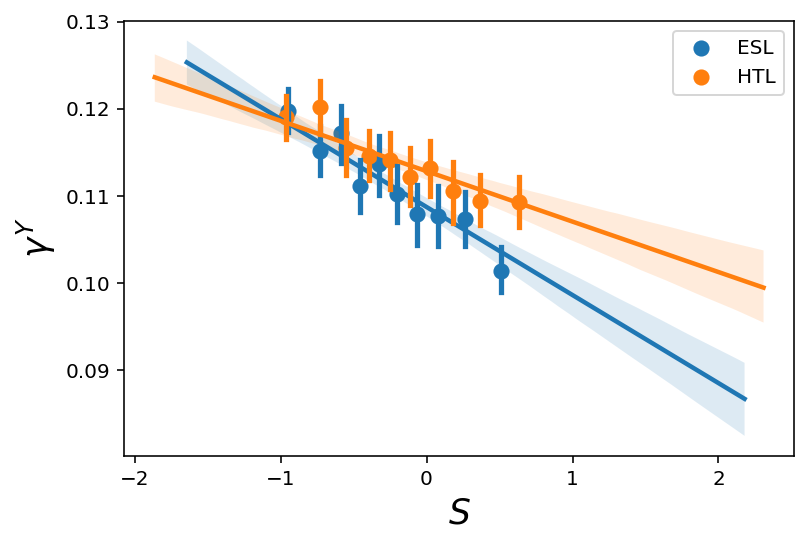

In [92]:
sns.regplot(x=output["soft"], y=strain, x_bins=10, label="ESL")
sns.regplot(x=htl_output["soft"], y=htl_strain, x_bins=10, label="HTL")
plt.legend()
plt.xlabel(r"$S$", size="xx-large")
plt.ylabel(r"$\gamma^Y$", size="xx-large")

In [93]:
zoft["mid"][::10,1].shape

(3277,)

Text(0, 0.5, '$\\gamma^Y$')

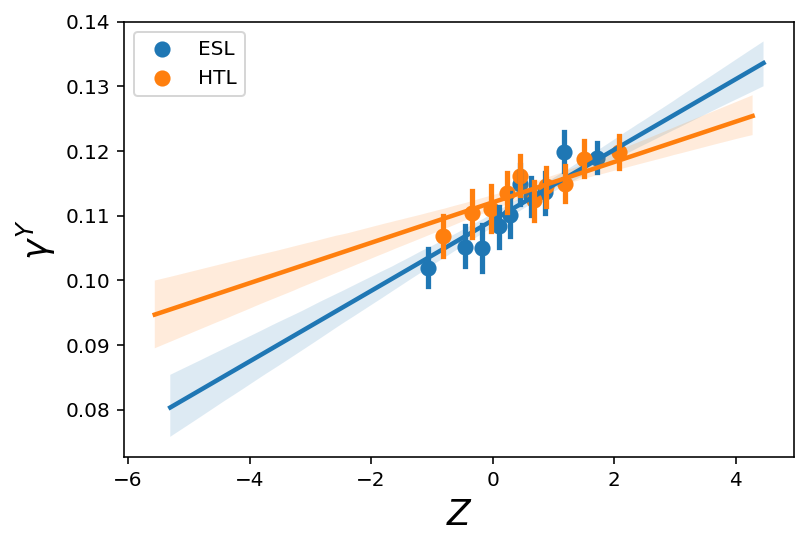

In [94]:
sns.regplot(x=zoft["mid"][::10,0], y=strain, x_bins=10, label="ESL")
sns.regplot(x=zoft["mid_htl"][::10,0], y=htl_strain, x_bins=10, label="HTL")
plt.legend()
plt.xlabel(r"$Z$", size="xx-large")
plt.ylabel(r"$\gamma^Y$", size="xx-large")

Text(0, 0.5, '$|\\sigma^Y_{dev}|$')

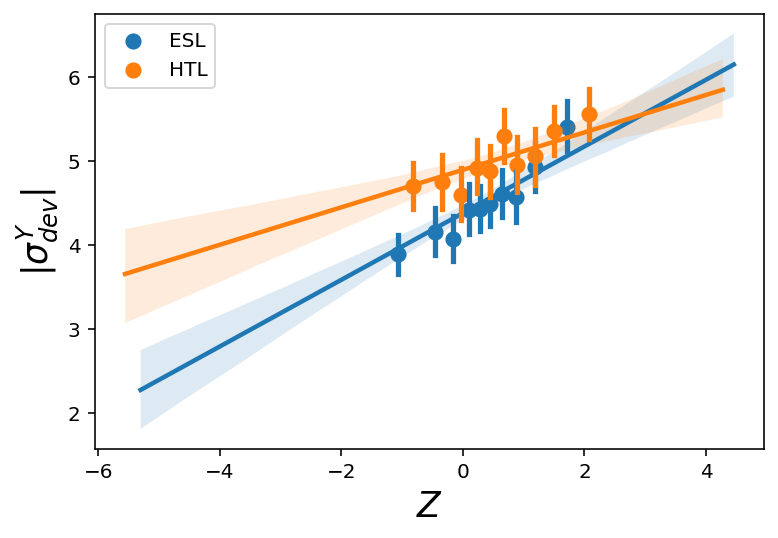

In [95]:
sns.regplot(x=zoft["mid"][::10,0], y=stress, x_bins=10, label="ESL")
sns.regplot(x=zoft["mid_htl"][::10,0], y=htl_stress, x_bins=10, label="HTL")
plt.legend()
plt.xlabel(r"$Z$", size="xx-large")
plt.ylabel(r"$|\sigma^Y_{dev}|$", size="xx-large")

In [96]:
def logit(x):
    return np.log(x/(1-x))

Text(0, 0.5, '$\\gamma^Y$')

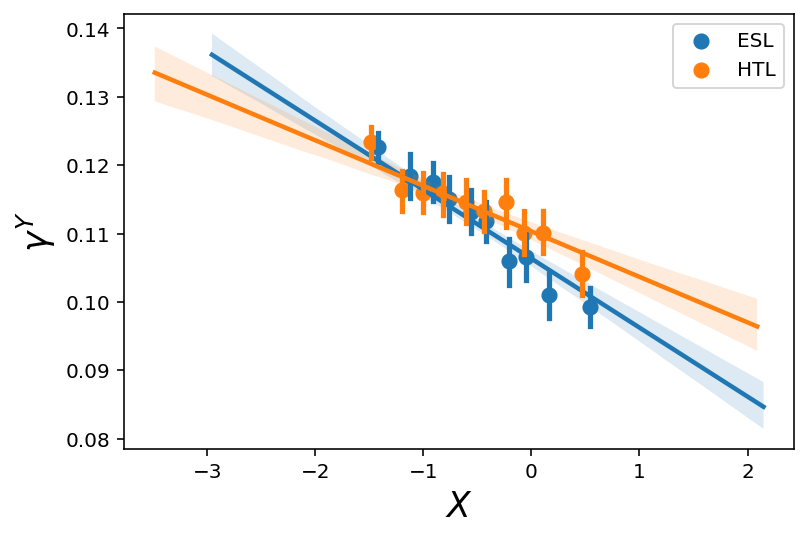

In [97]:
sns.regplot(x=logit(zoft["out"][::10]), y=strain, x_bins=10, label="ESL")
sns.regplot(x=logit(zoft["out_htl"][::10]), y=htl_strain, x_bins=10, label="HTL")
plt.legend()
plt.xlabel(r"$X$", size="xx-large")
plt.ylabel(r"$\gamma^Y$", size="xx-large")

Text(0, 0.5, '$|\\sigma^Y_{dev}|$')

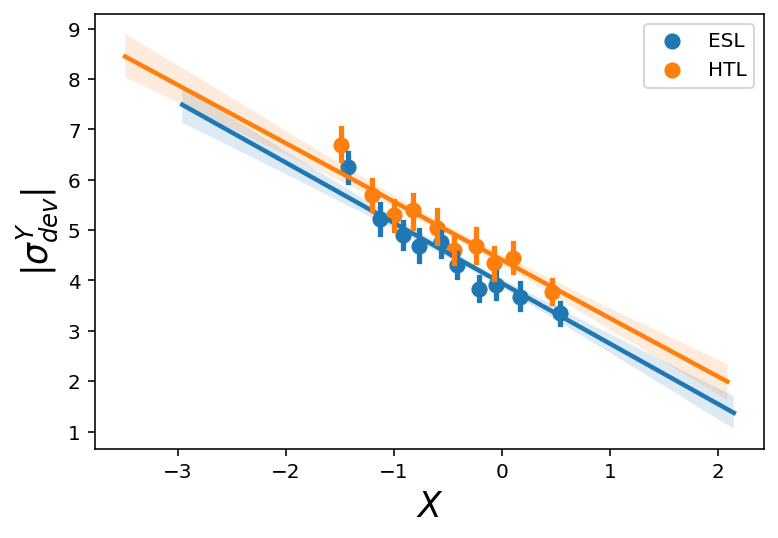

In [98]:
sns.regplot(x=logit(zoft["out"][::10]), y=stress, x_bins=10, label="ESL")
sns.regplot(x=logit(zoft["out_htl"][::10]), y=htl_stress, x_bins=10, label="HTL")
plt.legend()
plt.xlabel(r"$X$", size="xx-large")
plt.ylabel(r"$|\sigma^Y_{dev}|$", size="xx-large")

In [99]:
print(job)
files = glob.glob(job.fn("longer_experiments/max-shear-0.04/temp-1.9836e-02/traj-fire_period-1000.0.gsd"))
soft_df = pd.read_parquet(files[-1].replace("traj-fire_period-1000.0.gsd", "strob-softness_period-1000.0.parquet"), engine="pyarrow")

a8f2c249ed85533b56b0729b7ab96d18


In [100]:
soft_df.tail()

,frame,id,soft
195,7839,"[0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, ...","[-0.5569712, 0.8011457, 0.5402817, 0.15361041,..."
196,7879,"[0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, ...","[-0.56530493, 0.67400116, 0.81783813, 0.154904..."
197,7919,"[0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, ...","[-0.5611089, 0.6601351, 0.59369975, 0.1591719,..."
198,7959,"[0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, ...","[-0.5309705, 0.6674598, 0.57906926, 0.16605477..."
199,7999,"[0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, ...","[-0.49922734, 0.8167877, 0.62885255, 0.1661936..."


Text(0, 0.5, '$\\gamma^Y$')

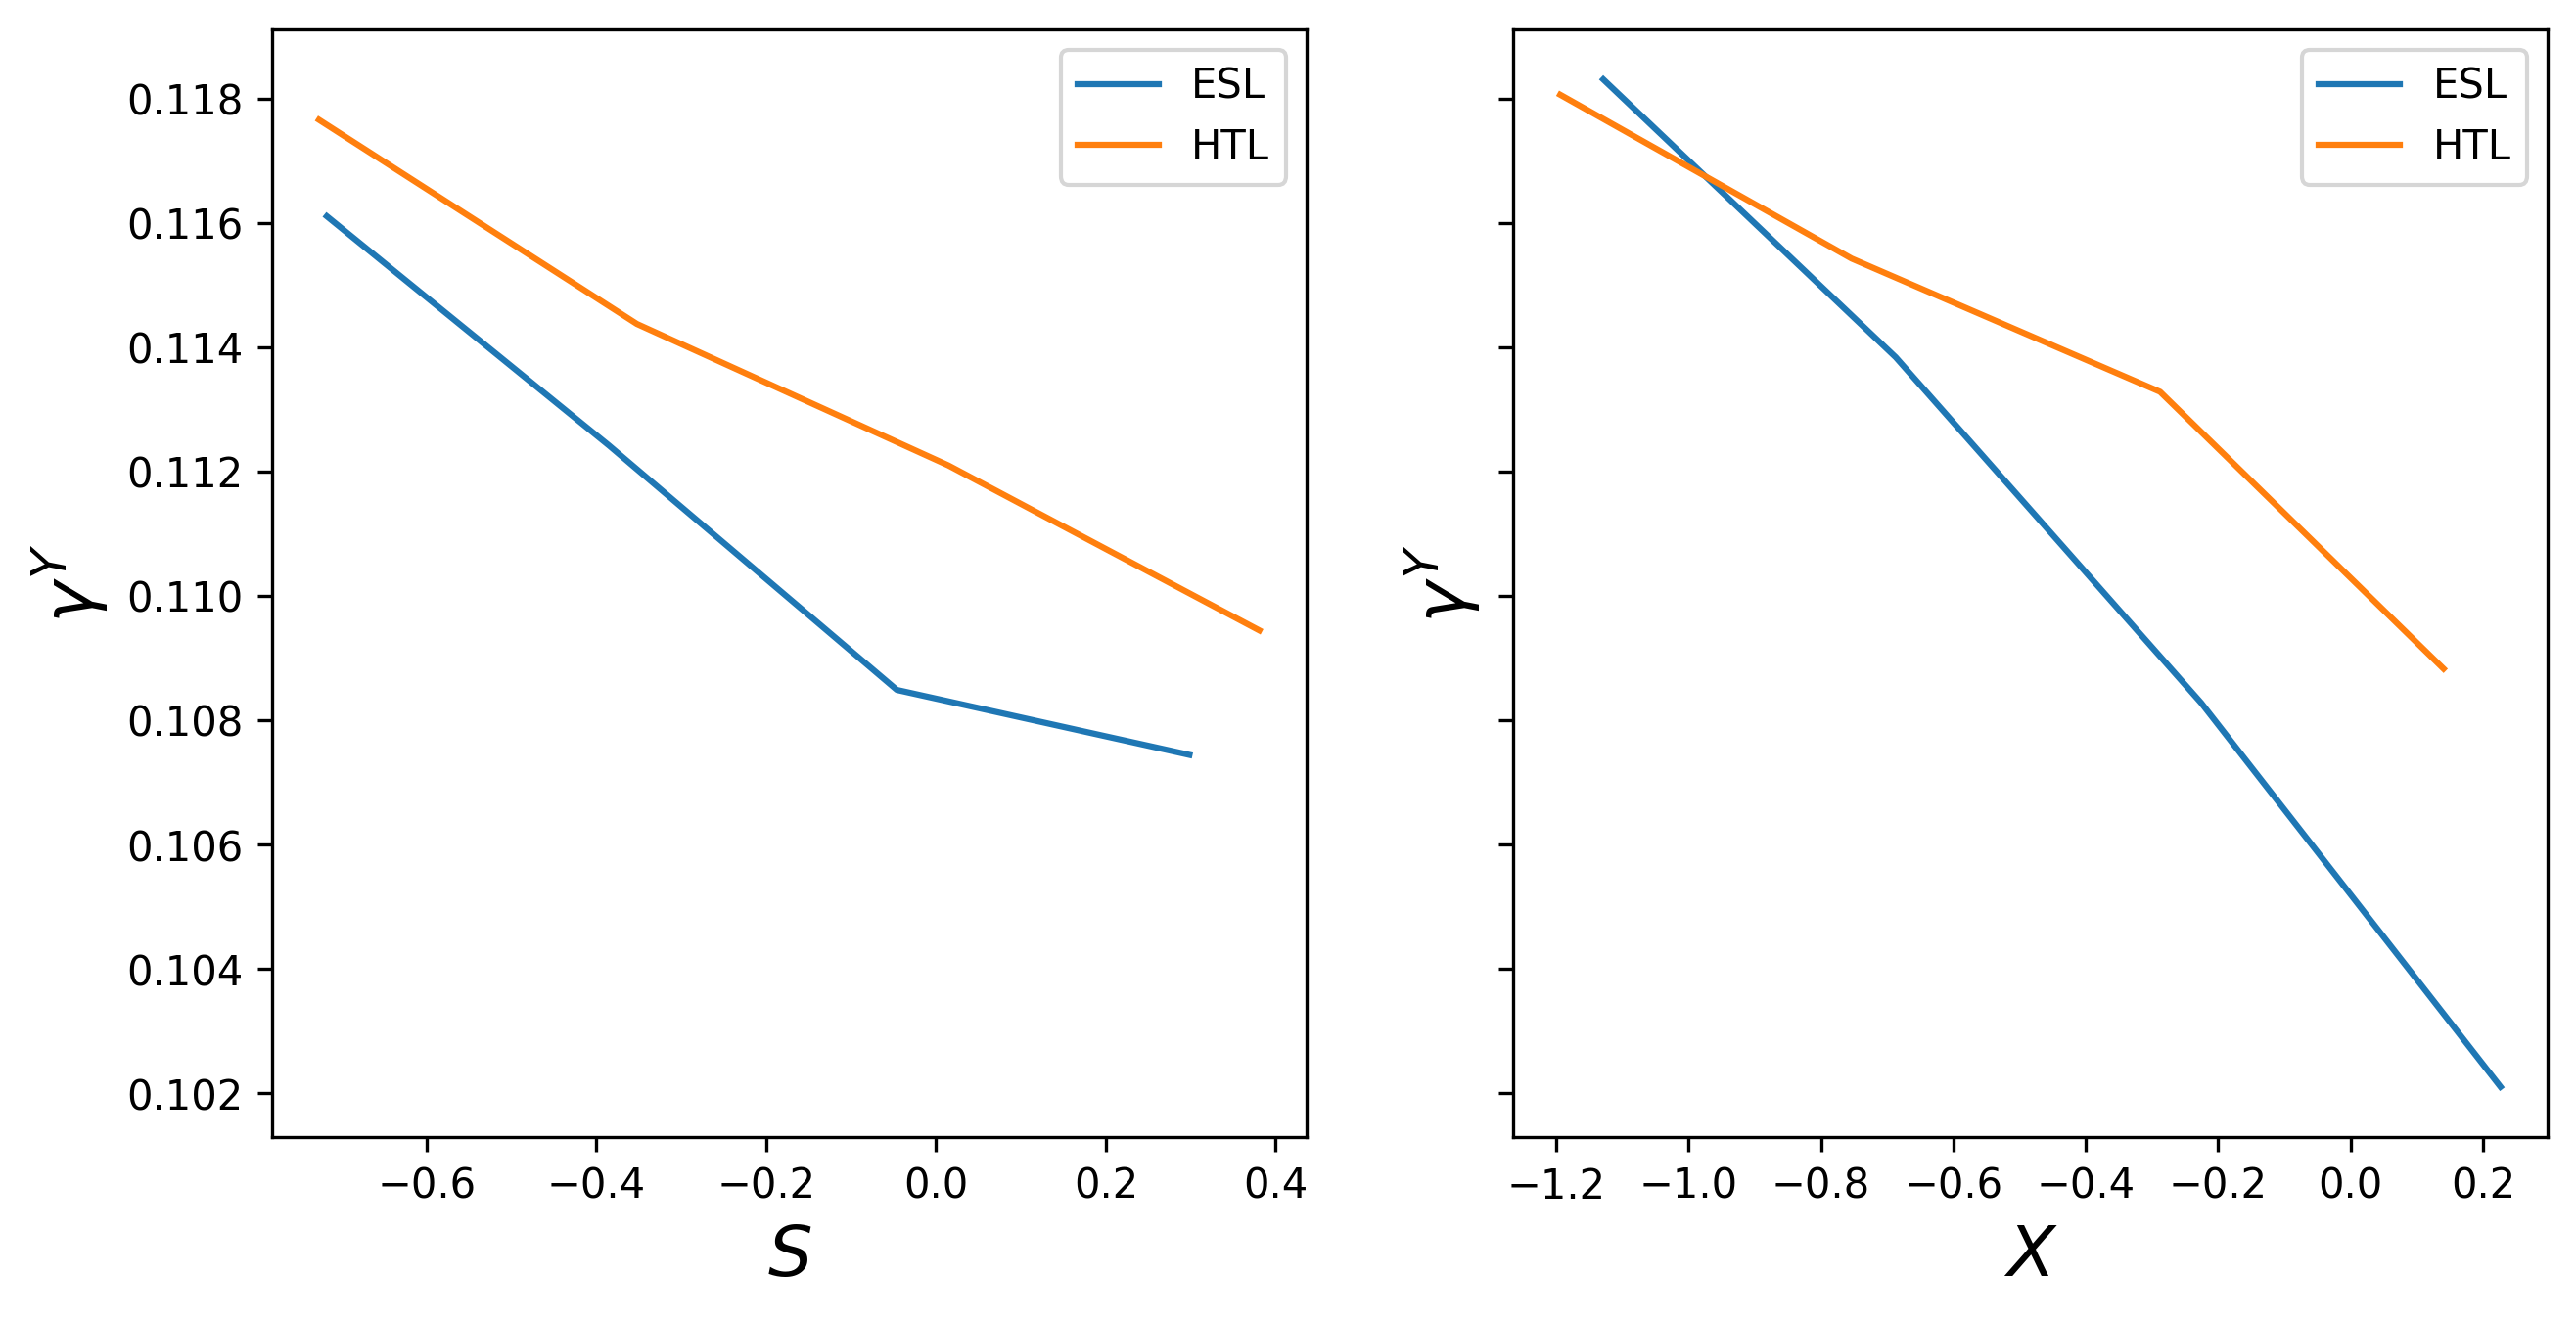

In [101]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), dpi=150, sharey=True)

nbins = 5

plt.sca(axs[0])
# sns.regplot(x=output["soft"], y=strain, x_bins=bins, label="ESL")
# sns.regplot(x=htl_output["soft"], y=htl_strain, x_bins=bins, label="HTL")
# cut into bins and plot
tdf = pd.DataFrame({"soft": output["soft"], "strain": strain})
q0 = tdf["soft"].quantile(0.1)
q1 = tdf["soft"].quantile(0.9)
bins = np.linspace(q0, q1, nbins)
tdf["bin"] = pd.cut(tdf["soft"], bins=bins)
tdf = tdf.groupby("bin").mean()
plt.plot(tdf["soft"], tdf["strain"], label="ESL")

tdf = pd.DataFrame({"soft": htl_output["soft"], "strain": htl_strain})
q0 = tdf["soft"].quantile(0.1)
q1 = tdf["soft"].quantile(0.9)
bins = np.linspace(q0, q1, nbins)
tdf["bin"] = pd.cut(tdf["soft"], bins=bins)
tdf = tdf.groupby("bin").mean()
plt.plot(tdf["soft"], tdf["strain"], label="HTL")
plt.legend()
plt.xlabel(r"$S$", size="xx-large")
plt.ylabel(r"$\gamma^Y$", size="xx-large")

plt.sca(axs[1])
# sns.regplot(x=logit(zoft["out"][::10]), y=strain, x_bins=bins, label="ESL")
# sns.regplot(x=logit(zoft["out_htl"][::10]), y=htl_strain, x_bins=bins,
# label="HTL")
tdf = pd.DataFrame({"soft": logit(zoft["out"][::10].reshape(-1)), "strain": strain})
q0 = tdf["soft"].quantile(0.1)
q1 = tdf["soft"].quantile(0.9)
bins = np.linspace(q0, q1, nbins)
tdf["bin"] = pd.cut(tdf["soft"], bins=bins)
tdf = tdf.groupby("bin").mean()
plt.plot(tdf["soft"], tdf["strain"], label="ESL")

tdf = pd.DataFrame({"soft": logit(zoft["out_htl"][::10].reshape(-1)), "strain": htl_strain})
q0 = tdf["soft"].quantile(0.1)
q1 = tdf["soft"].quantile(0.9)
bins = np.linspace(q0, q1, nbins)
tdf["bin"] = pd.cut(tdf["soft"], bins=bins)
tdf = tdf.groupby("bin").mean()
plt.plot(tdf["soft"], tdf["strain"], label="HTL")
plt.legend()
plt.xlabel(r"$X$", size="xx-large")
plt.ylabel(r"$\gamma^Y$", size="xx-large")

Text(0, 0.5, '$\\gamma^Y$')

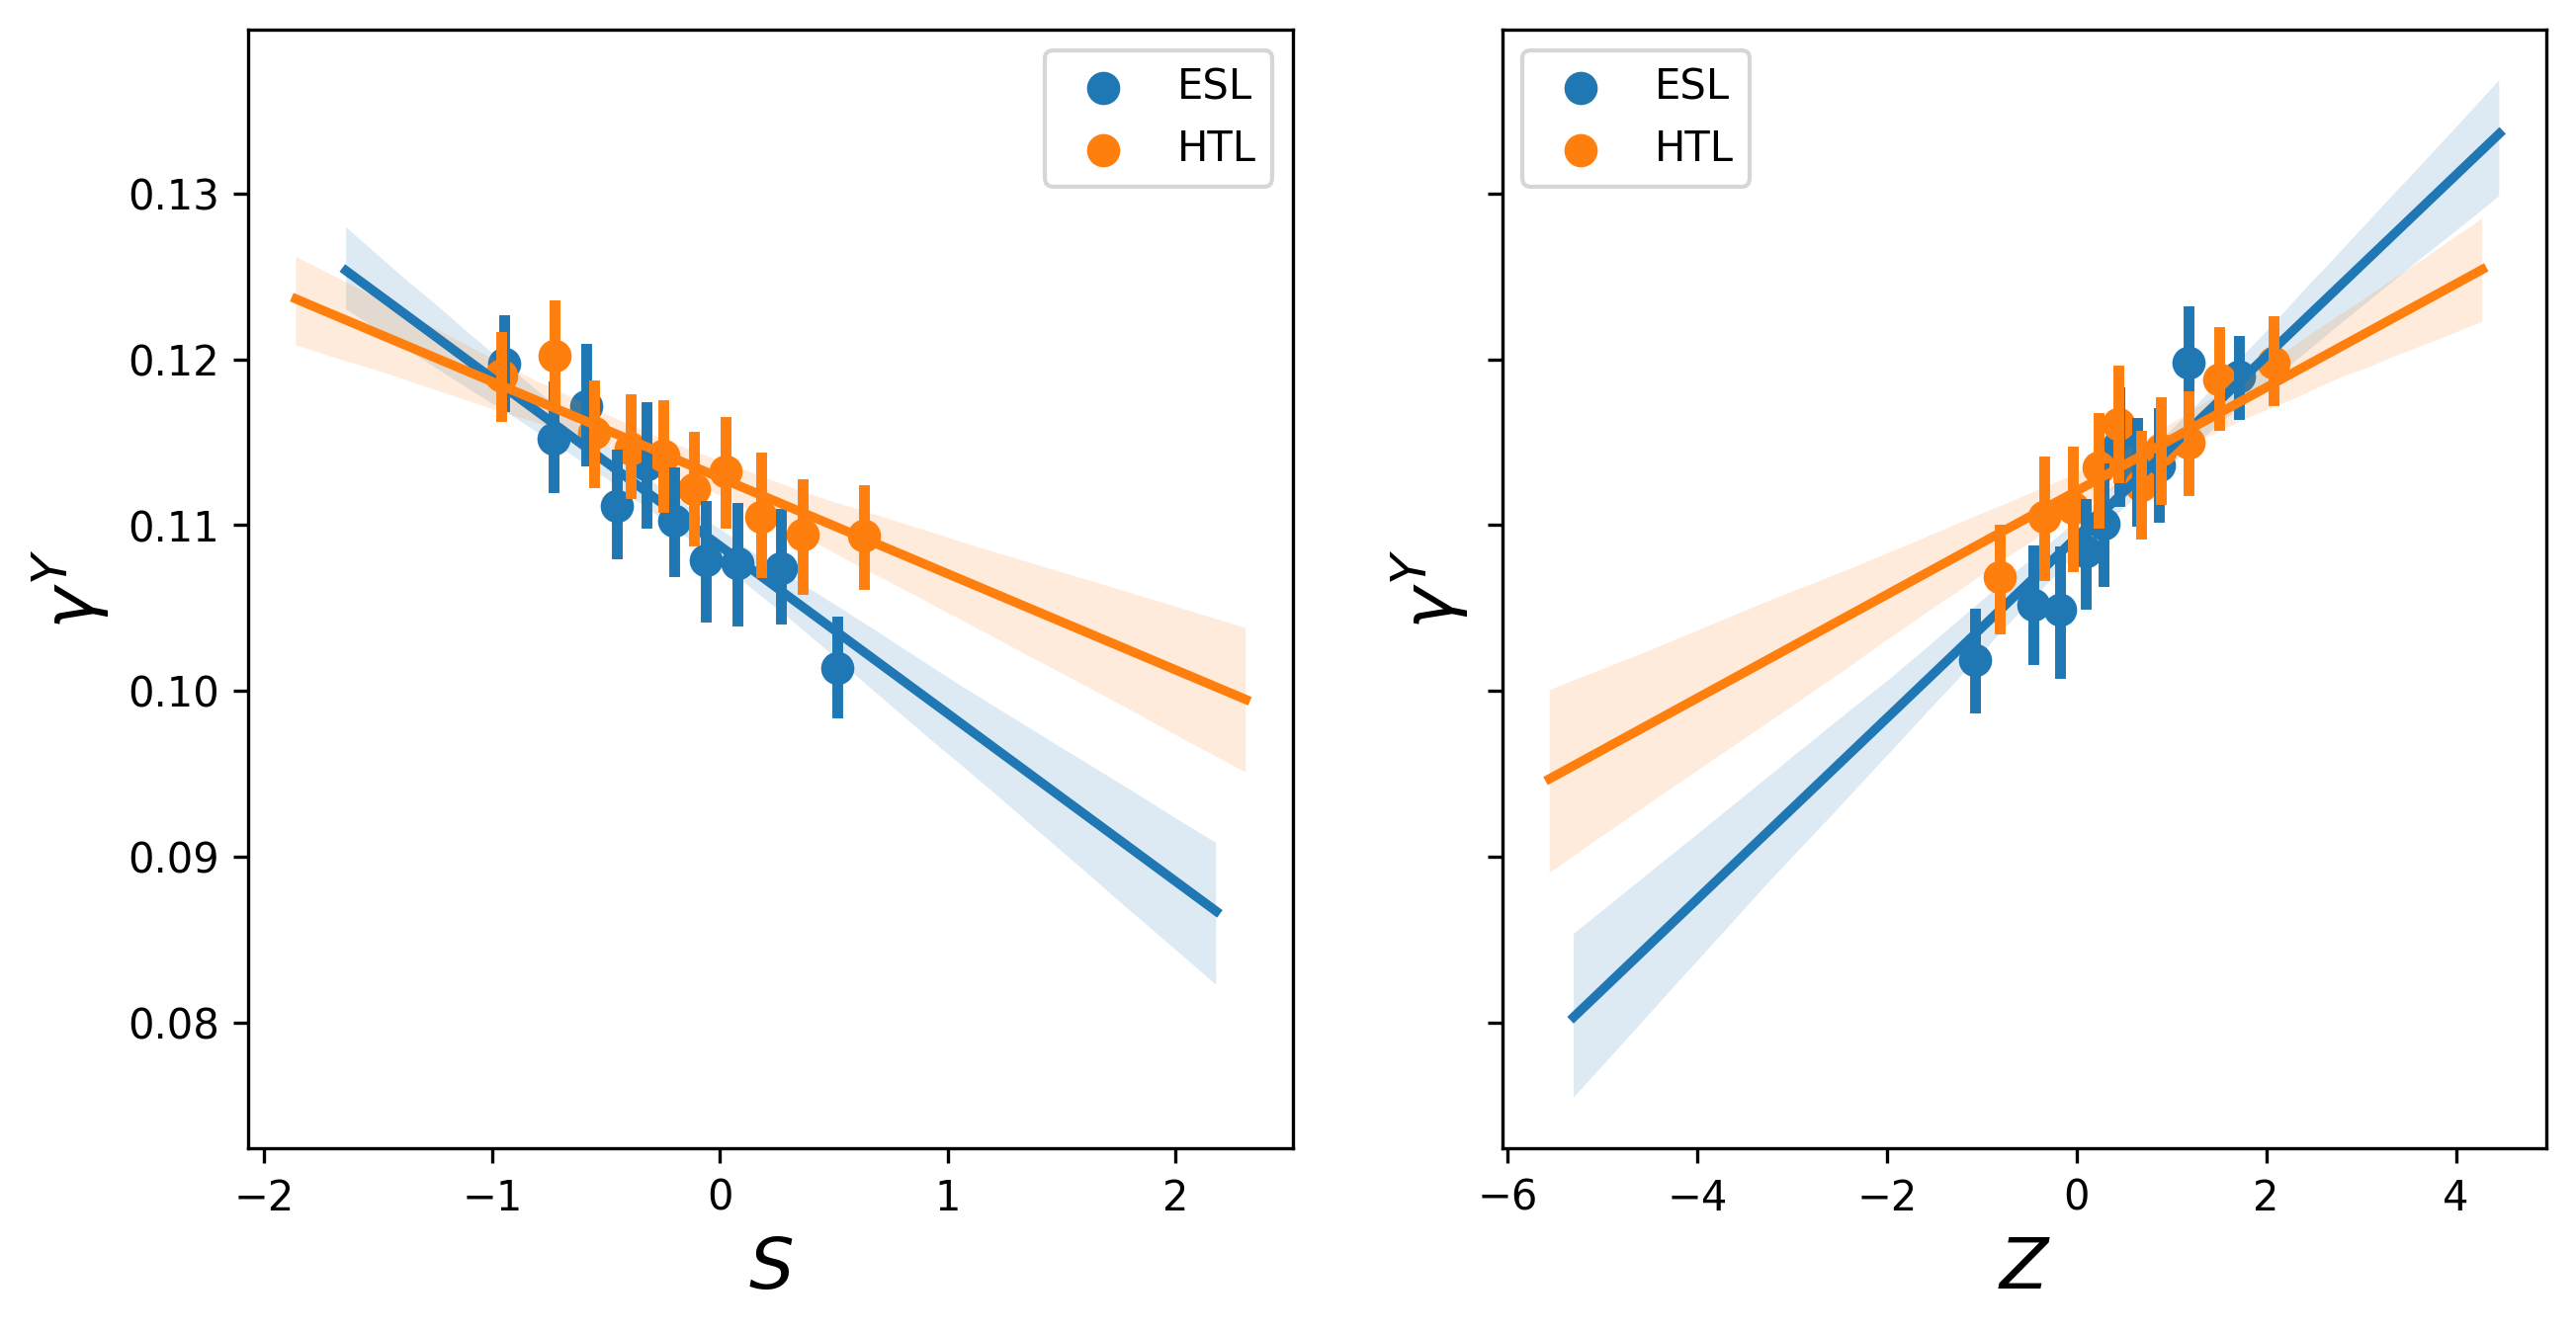

In [102]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), dpi=150, sharey=True)

plt.sca(axs[0])
sns.regplot(x=output["soft"], y=strain, x_bins=10, label="ESL")
sns.regplot(x=htl_output["soft"], y=htl_strain, x_bins=10, label="HTL")
plt.legend()
plt.xlabel(r"$S$", size="xx-large")
plt.ylabel(r"$\gamma^Y$", size="xx-large")

plt.sca(axs[1])
sns.regplot(x=zoft["mid"][::10, 0], y=strain, x_bins=10, label="ESL")
sns.regplot(x=zoft["mid_htl"][::10, 0], y=htl_strain, x_bins=10, label="HTL")
plt.legend()
plt.xlabel(r"$Z$", size="xx-large")
plt.ylabel(r"$\gamma^Y$", size="xx-large")

Text(0, 0.5, '$|\\sigma^Y_{dev}|$')

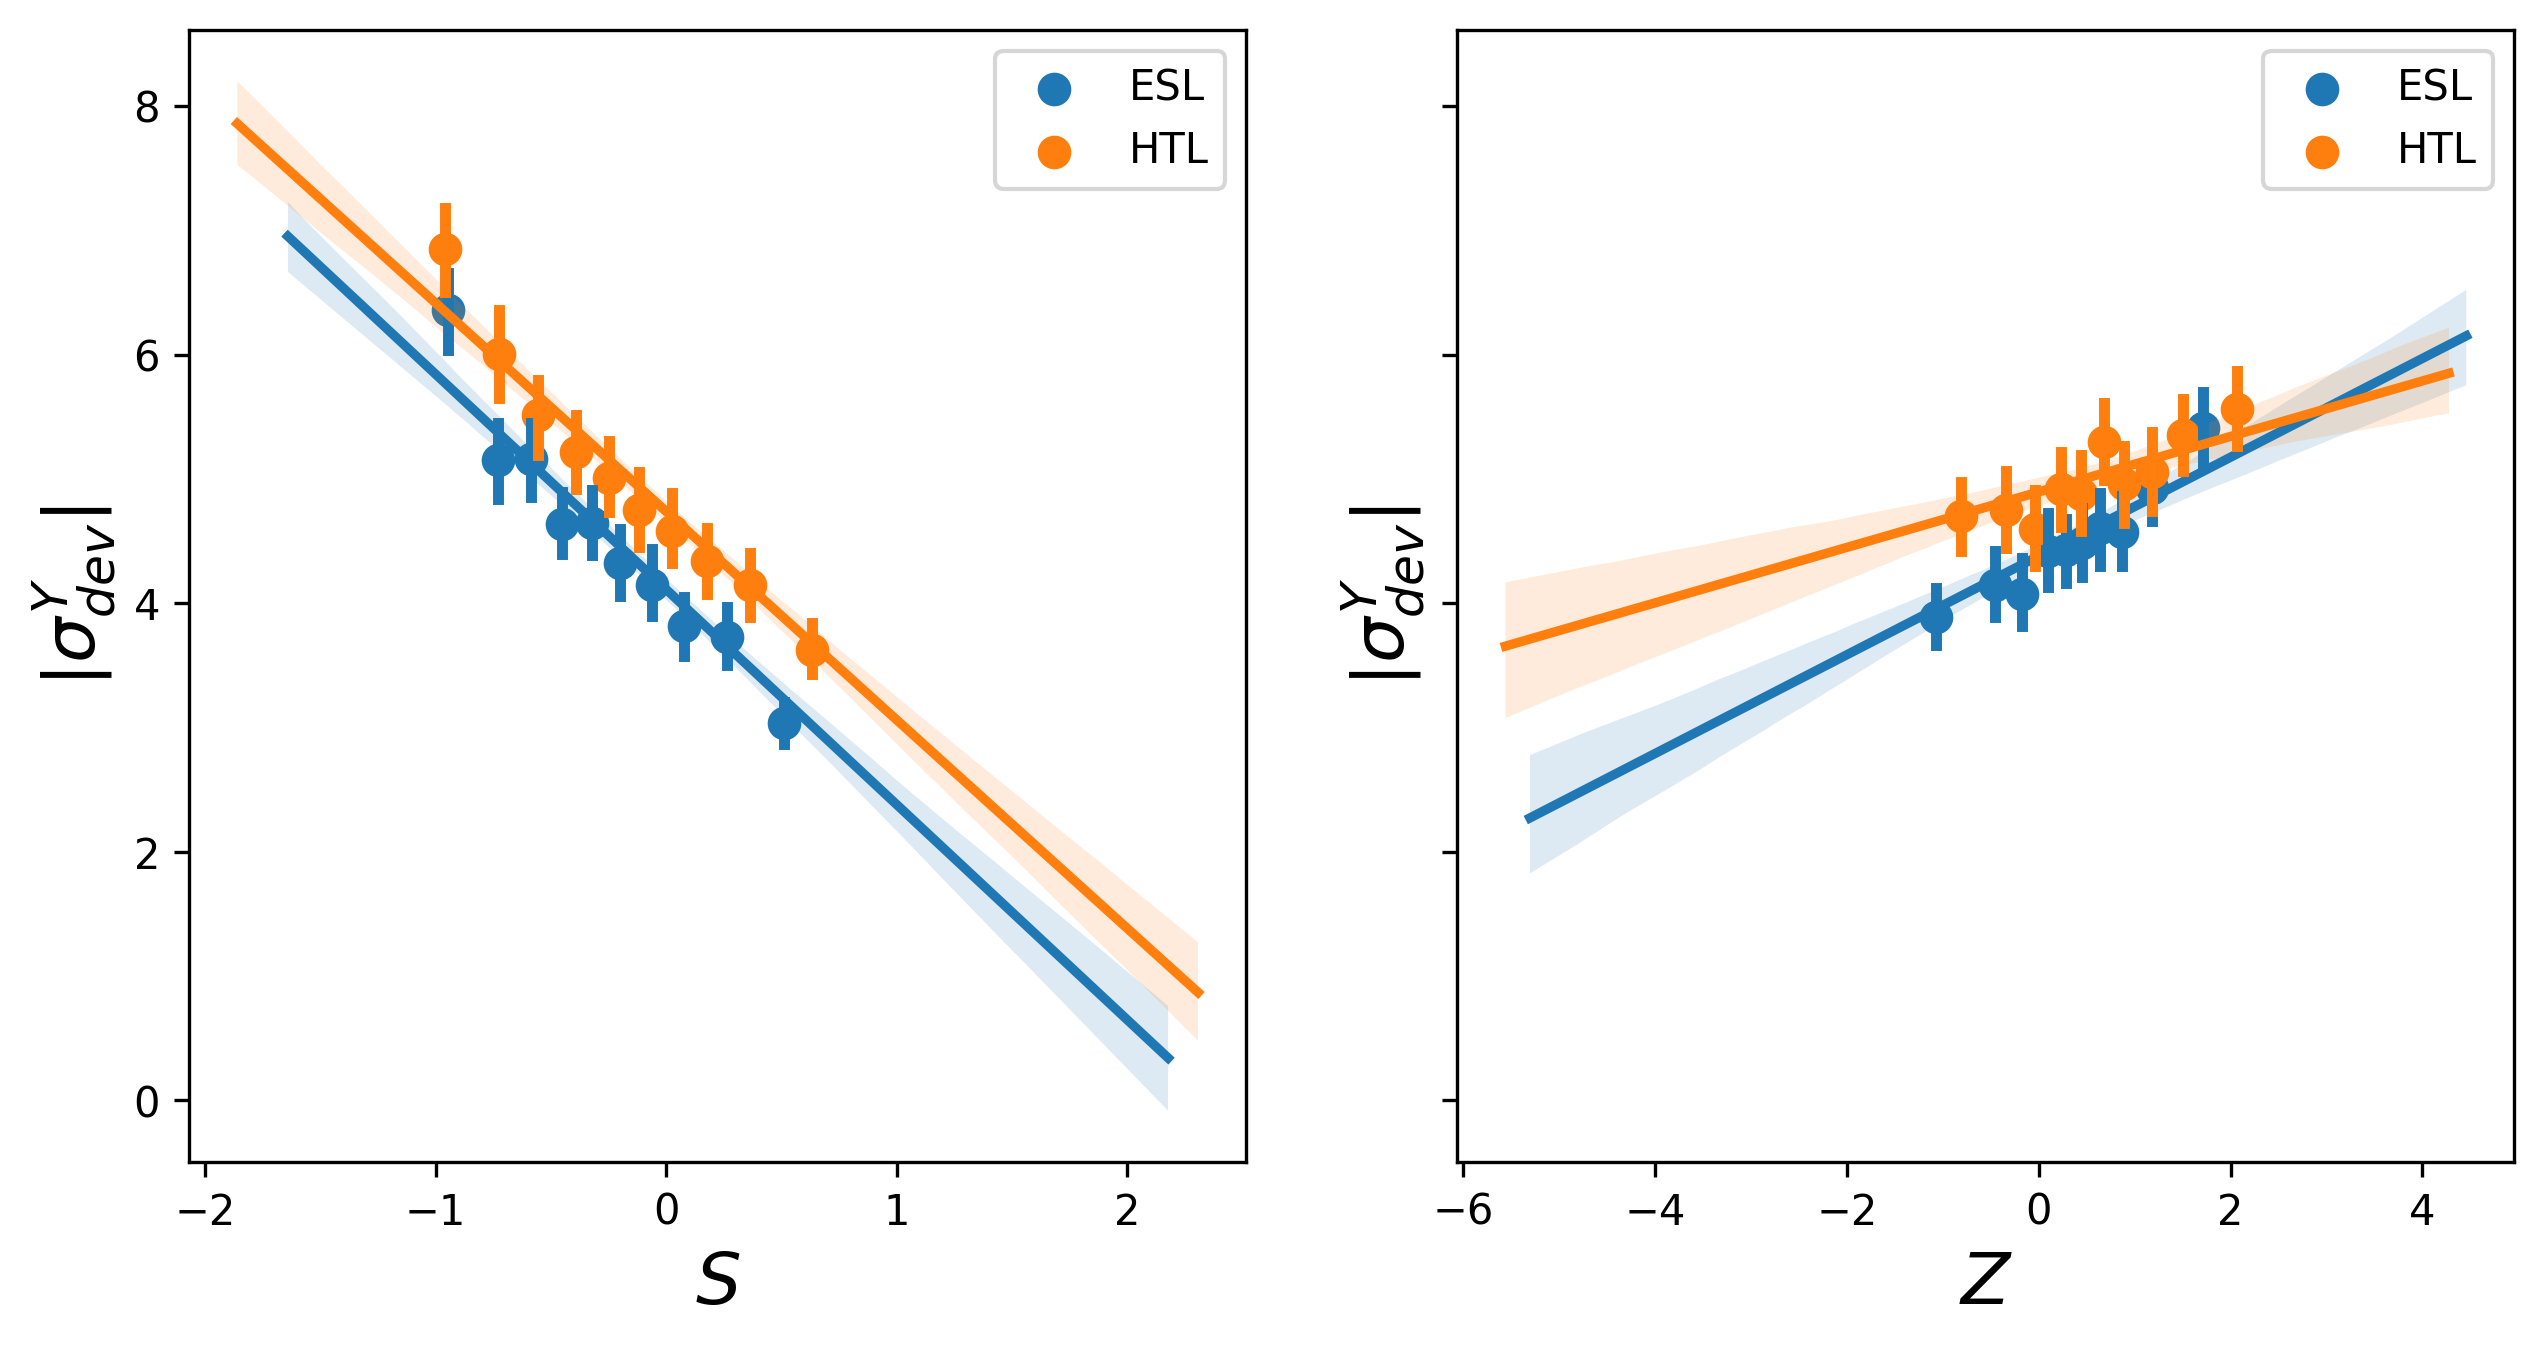

In [103]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), dpi=150, sharey=True)

plt.sca(axs[0])
sns.regplot(x=output["soft"], y=stress, x_bins=10, label="ESL")
sns.regplot(x=htl_output["soft"], y=htl_stress, x_bins=10, label="HTL")
plt.legend()
plt.xlabel(r"$S$", size="xx-large")
plt.ylabel(r"$|\sigma^Y_{dev}|$", size="xx-large")

plt.sca(axs[1])
sns.regplot(x=zoft["mid"][::10, 0], y=stress, x_bins=10, label="ESL")
sns.regplot(x=zoft["mid_htl"][::10, 0], y=htl_stress, x_bins=10, label="HTL")
plt.legend()
plt.xlabel(r"$Z$", size="xx-large")

plt.ylabel(r"$|\sigma^Y_{dev}|$", size="xx-large")

Text(0, 0.5, '$|\\sigma^Y_{dev}| - \\langle|\\sigma^Y_{dev}|\\rangle$')

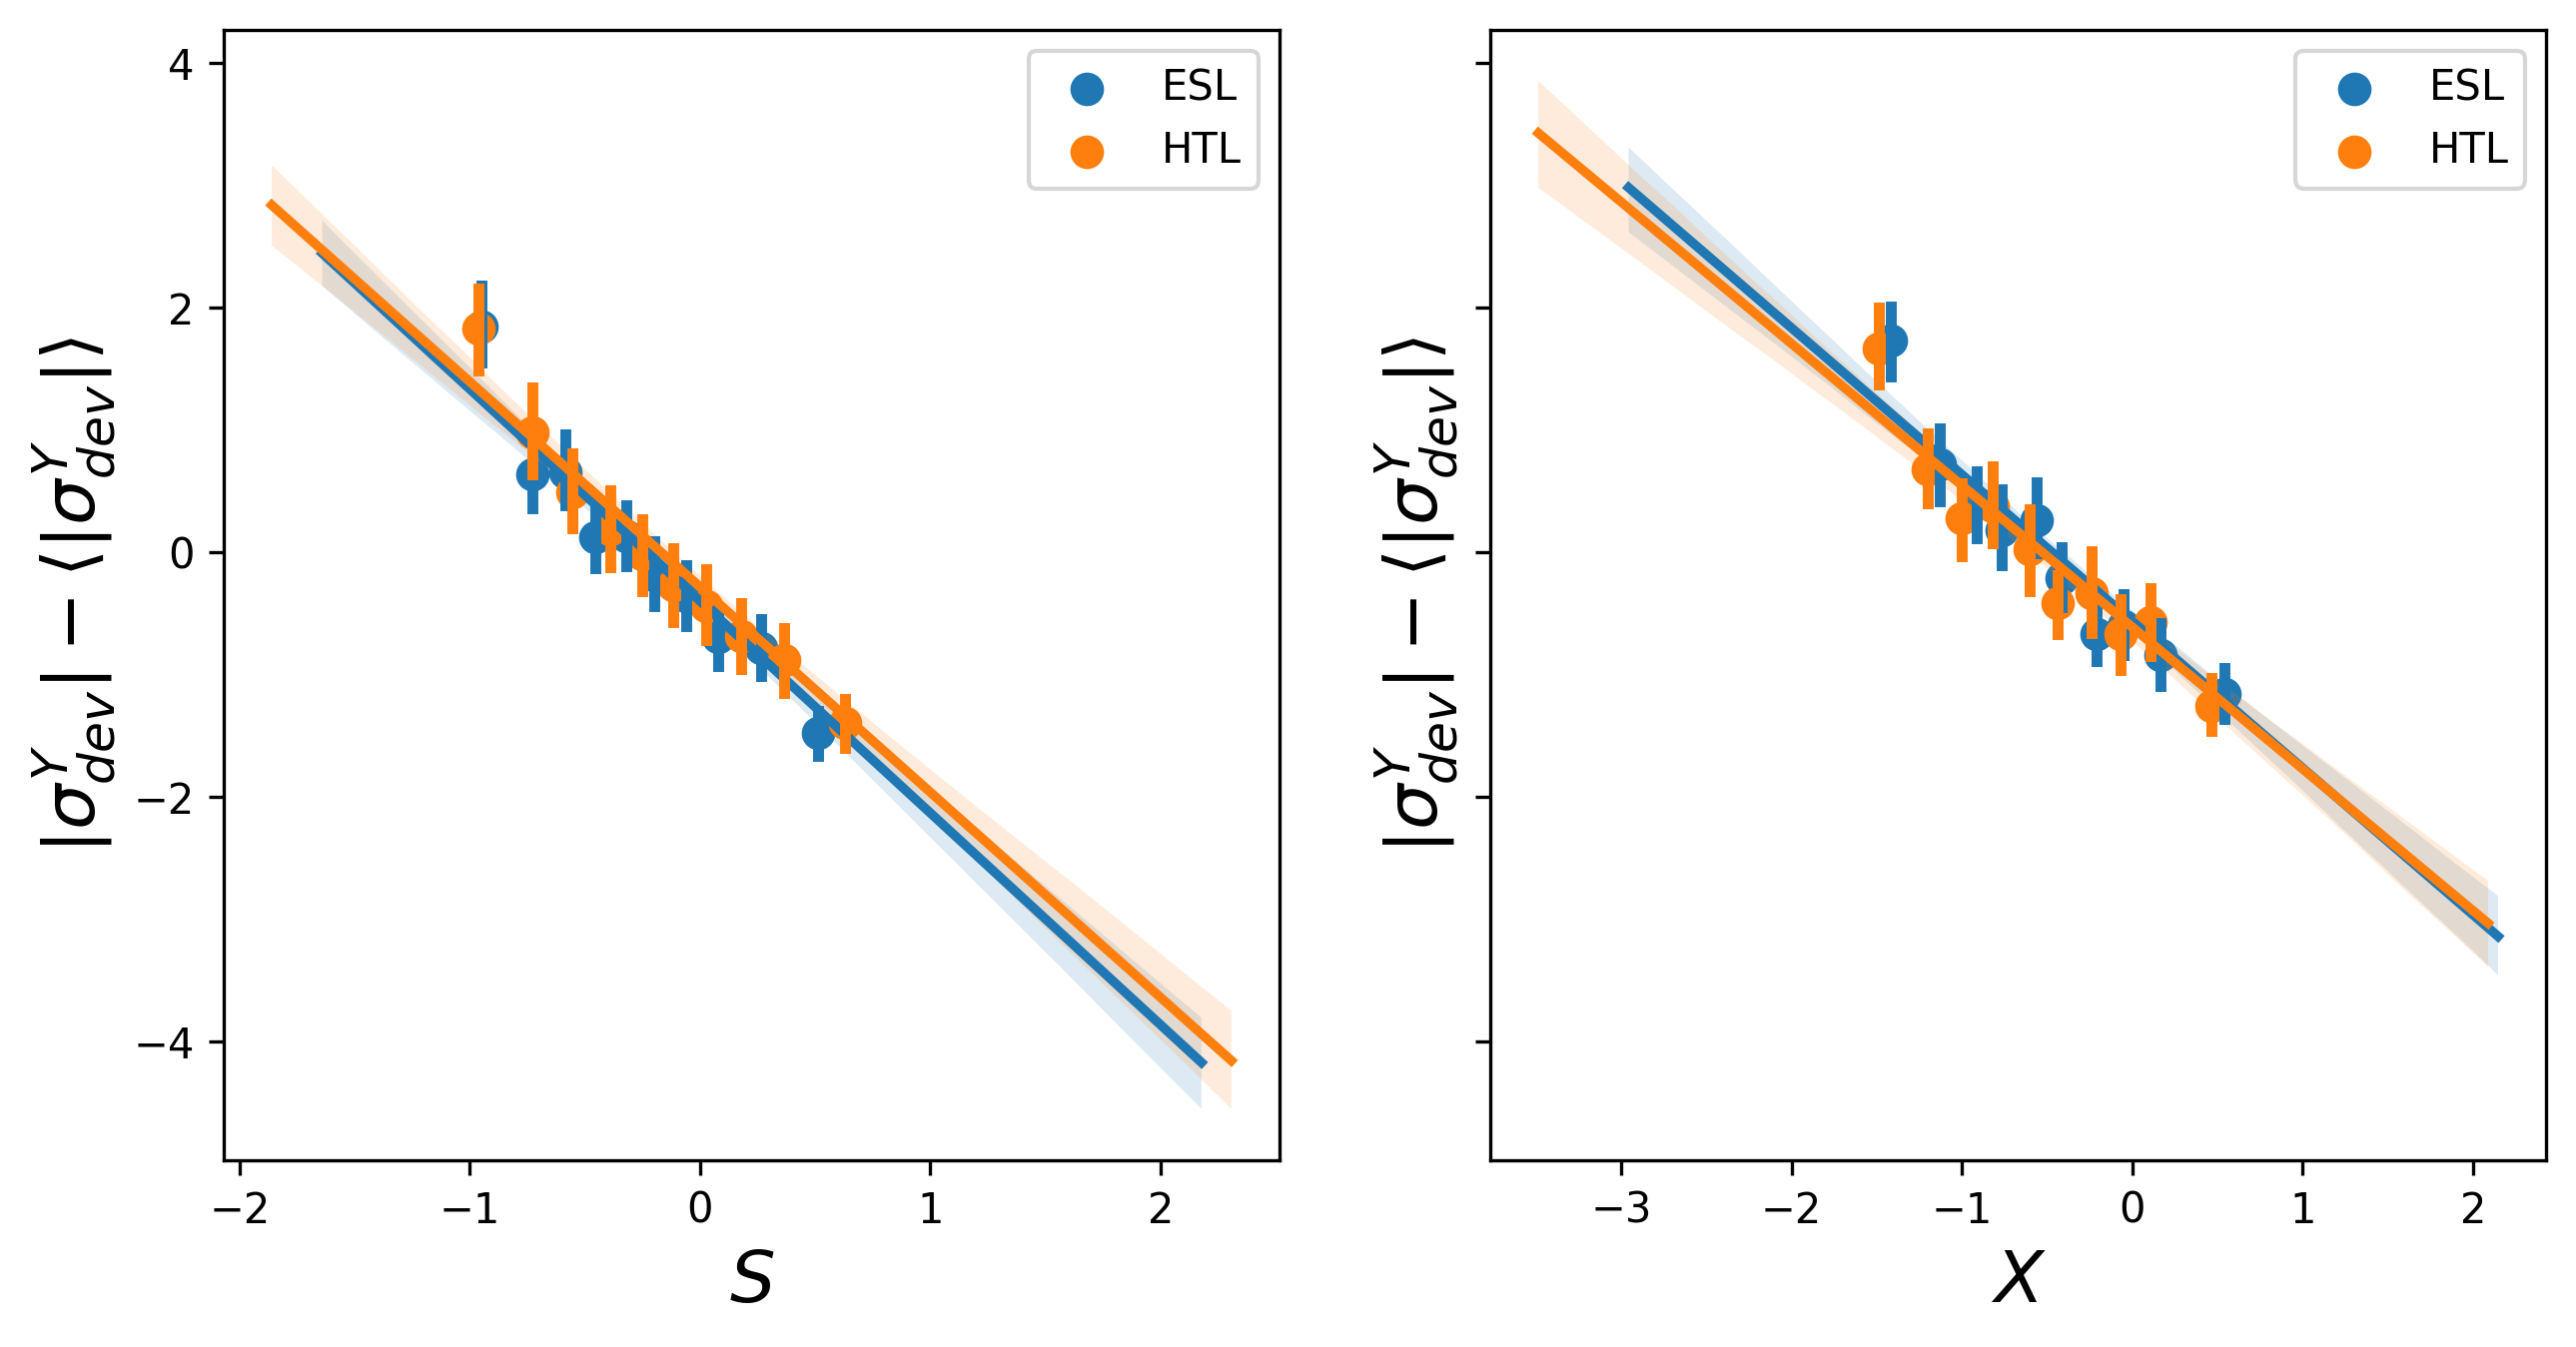

In [104]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), dpi=150, sharey=True)

bins = 10

plt.sca(axs[0])
sns.regplot(x=output["soft"], y=stress - np.mean(stress), x_bins=bins, label="ESL")
sns.regplot(x=htl_output["soft"], y=htl_stress - np.mean(htl_stress), x_bins=bins, label="HTL")
plt.legend()
plt.xlabel(r"$S$", size="xx-large")
plt.ylabel(r"$|\sigma^Y_{dev}| - \langle|\sigma^Y_{dev}|\rangle$", size="xx-large")

plt.sca(axs[1])
sns.regplot(x=logit(zoft["out"][::10]), y=stress - np.mean(stress), x_bins=bins, label="ESL")
sns.regplot(x=logit(zoft["out_htl"][::10]), y=htl_stress - np.mean(htl_stress), x_bins=bins, label="HTL")
plt.legend()
plt.xlabel(r"$X$", size="xx-large")

plt.ylabel(r"$|\sigma^Y_{dev}| - \langle|\sigma^Y_{dev}|\rangle$", size="xx-large")

In [110]:
H, bx, by = np.histogram2d(zoft["mid"][::10, 1], zoft["mid"][::10, 0], bins=20, weights=stress)
N, nx, ny = np.histogram2d(zoft["mid"][::10, 1], zoft["mid"][::10, 0], bins=[bx, by])

In [111]:
out = H/N
# out = np.nan_to_num(out)

/tmp/ipykernel_3651406/3999495866.py:1: RuntimeWarning: invalid value encountered in divide
  out = H/N


In [112]:
np.nanmax(out)

10.80840231423181

Text(0, 0.5, '$Z$')

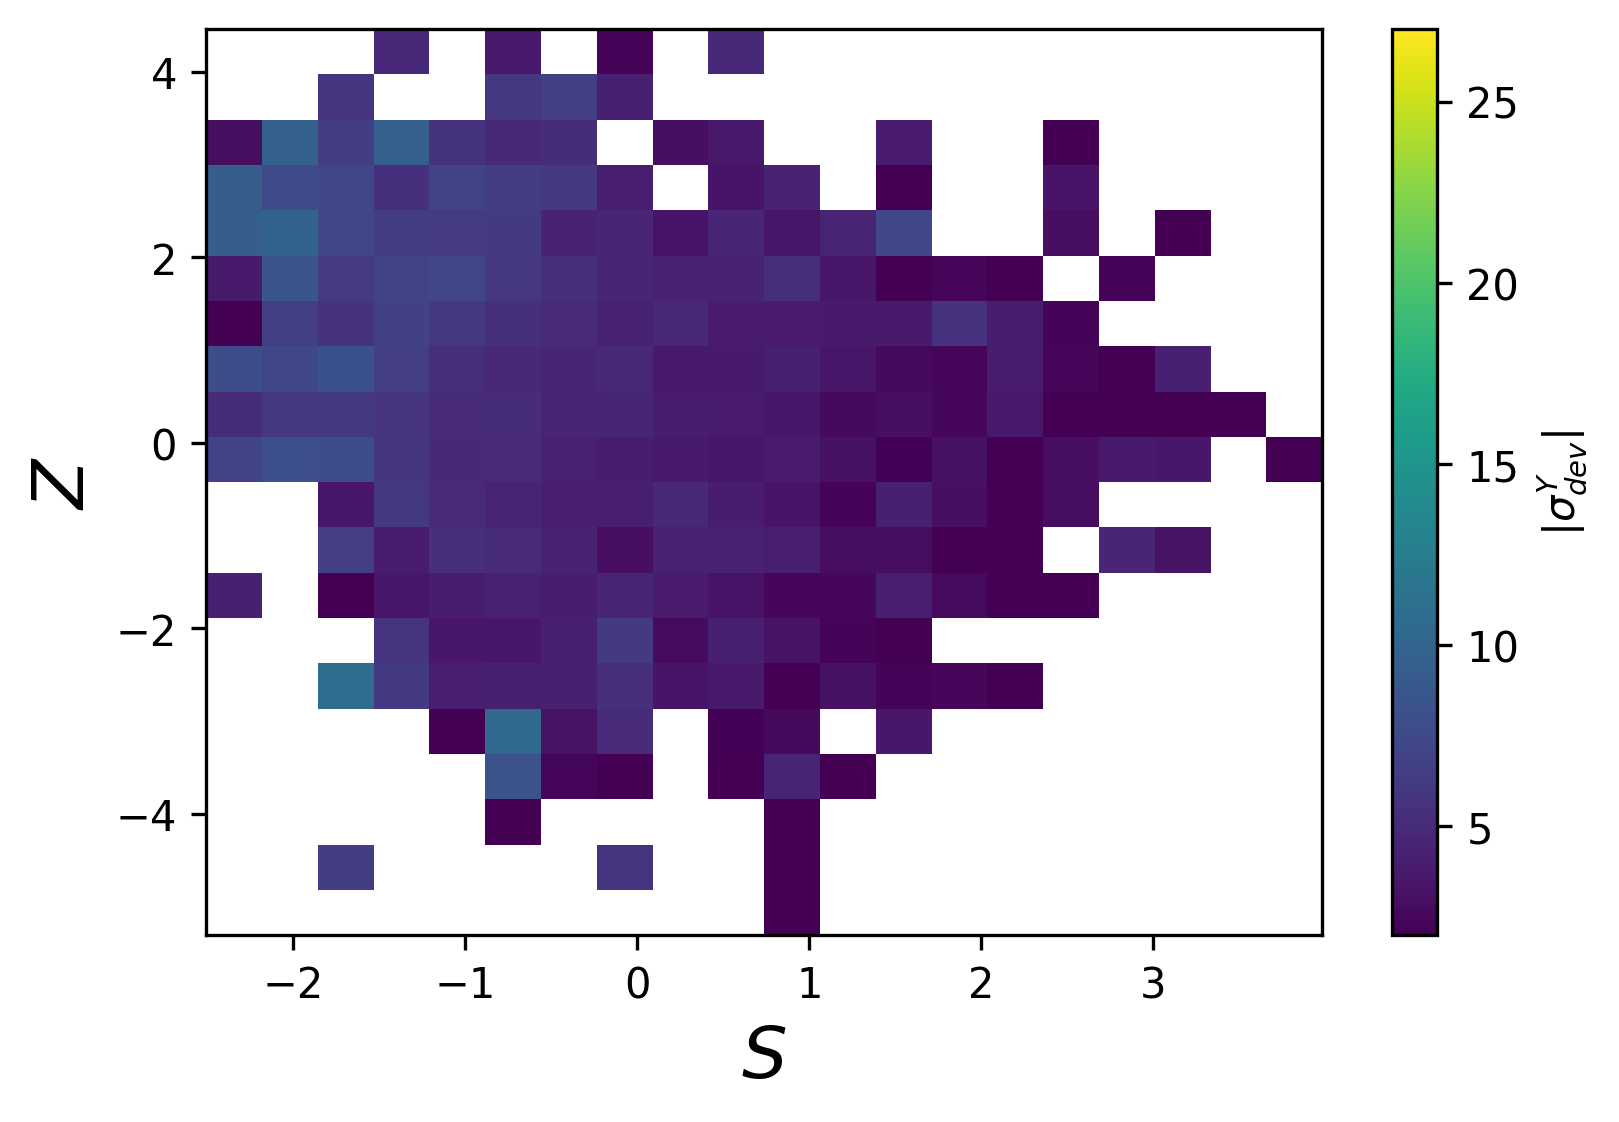

In [113]:
plt.figure(dpi=150)
norm = mpl.colors.Normalize(vmin=2, vmax=27)
plt.pcolormesh(bx, by, out.T, cmap="viridis", norm=norm)
plt.colorbar(label=r"$|\sigma^Y_{dev}|$")
plt.xlabel(r"$S$", size="xx-large")
plt.ylabel(r"$Z$", size="xx-large")

In [114]:
H, bx1, by1 = np.histogram2d(zoft["mid_htl"][::10, 1], zoft["mid_htl"][::10, 0], bins=20, weights=htl_stress)
N, nx, ny = np.histogram2d(zoft["mid_htl"][::10, 1], zoft["mid_htl"][::10, 0], bins=[bx1, by1])

out_htl = H/N
# out = np.nan_to_num(out)

/tmp/ipykernel_3651406/1099119493.py:4: RuntimeWarning: invalid value encountered in divide
  out_htl = H/N


Text(0.5, 1.0, 'HTL')

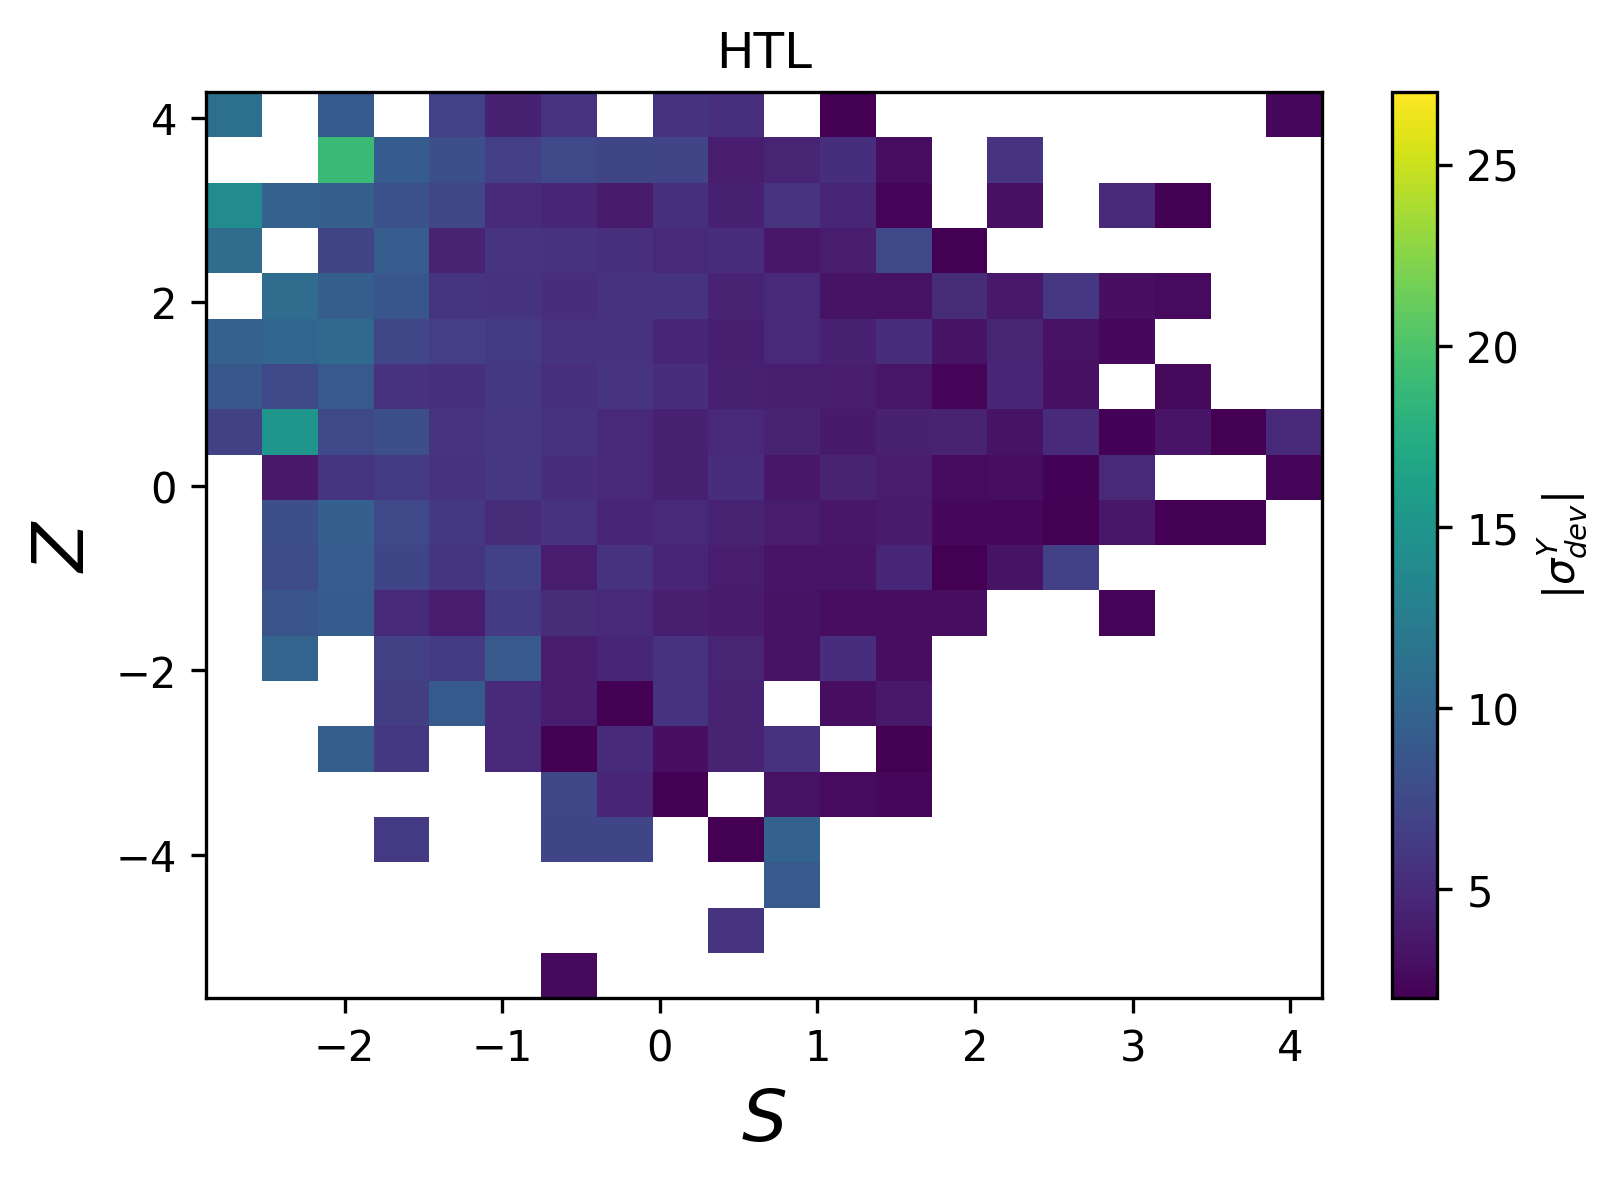

In [115]:
plt.figure(dpi=150)
plt.pcolormesh(bx1, by1, out_htl.T, cmap="viridis", norm=norm)
plt.colorbar(label=r"$|\sigma^Y_{dev}|$")
plt.xlabel(r"$S$", size="xx-large")
plt.ylabel(r"$Z$", size="xx-large")
plt.title("HTL")

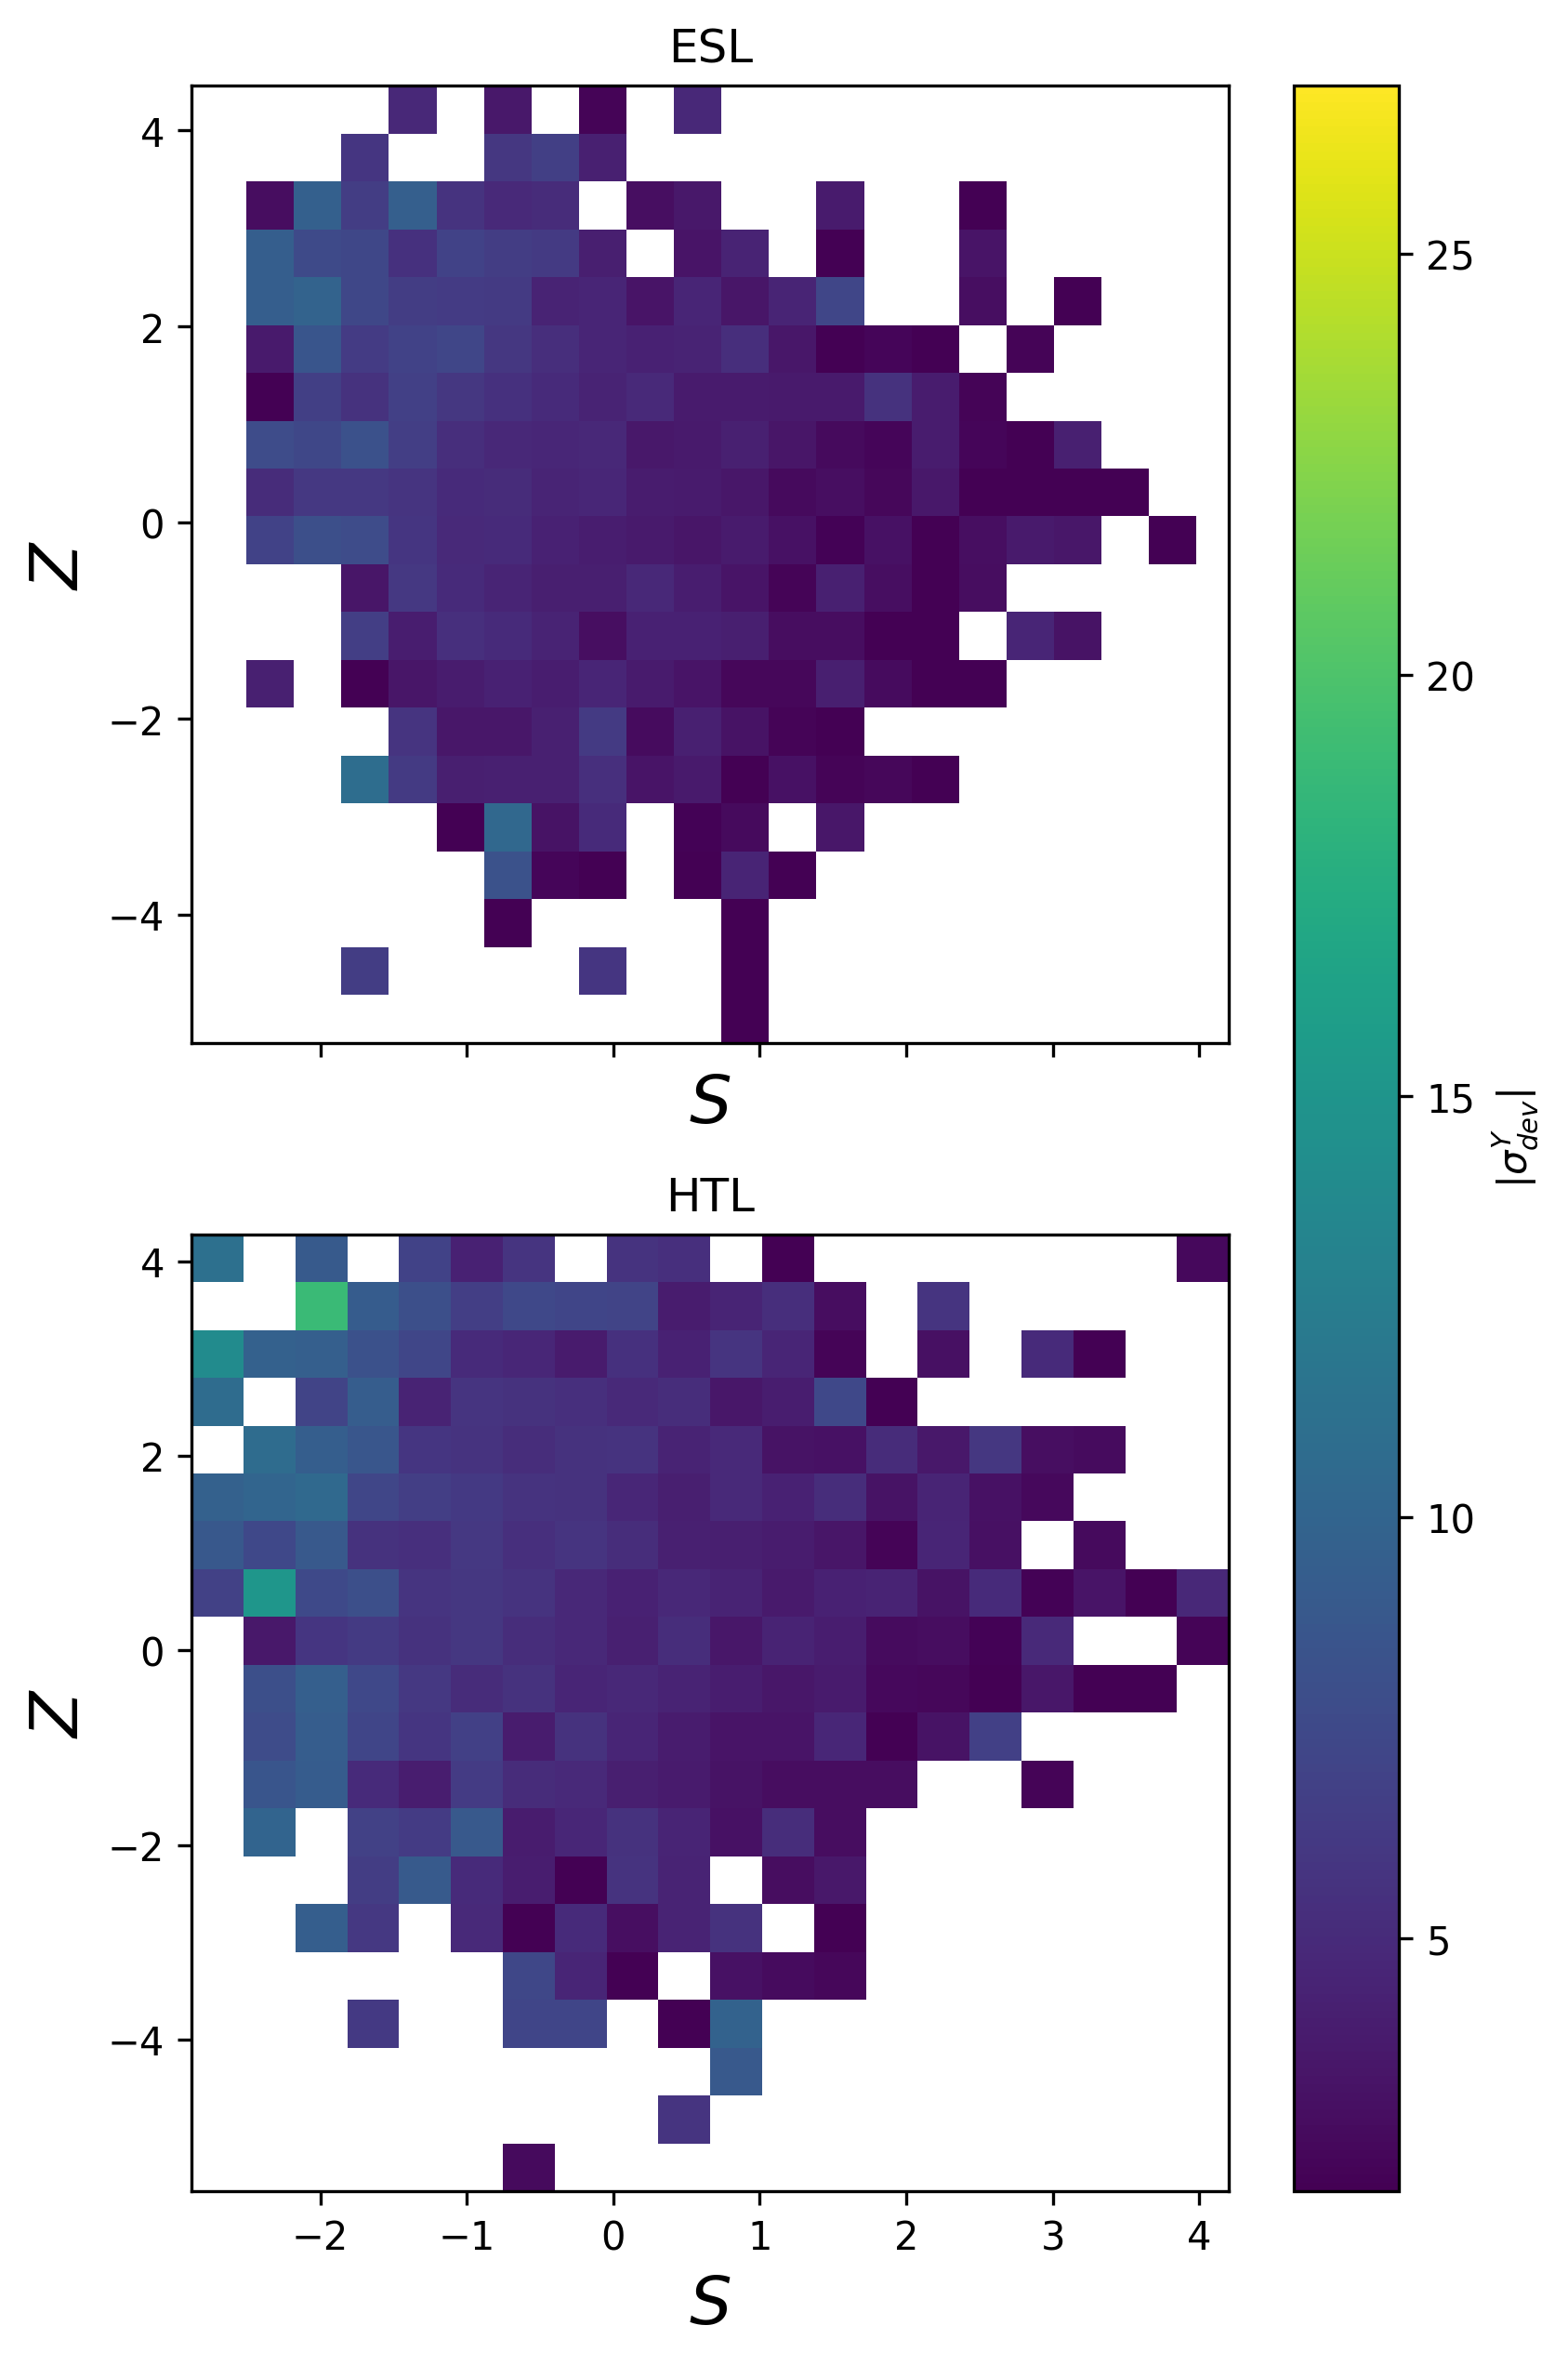

In [116]:
fig, axs = plt.subplots(2, 1, figsize=(6, 10), dpi=150, sharex=True)

plt.sca(axs[0])
norm = mpl.colors.Normalize(vmin=2, vmax=27)
plt.pcolormesh(bx, by, out.T, cmap="viridis", norm=norm)
# plt.colorbar(label=r"$|\sigma^Y_{dev}|$")
plt.xlabel(r"$S$", size="xx-large")
plt.ylabel(r"$Z$", size="xx-large")
plt.title("ESL")

plt.sca(axs[1])
# plt.figure(dpi=150)
im1 = plt.pcolormesh(bx1, by1, out_htl.T, cmap="viridis", norm=norm)
# plt.colorbar(label=r"$|\sigma^Y_{dev}|$")
plt.xlabel(r"$S$", size="xx-large")
plt.ylabel(r"$Z$", size="xx-large")
plt.title("HTL")

fig.colorbar(im1, ax=axs, label=r"$|\sigma^Y_{dev}|$")

Text(0.5, 0, '$X$')

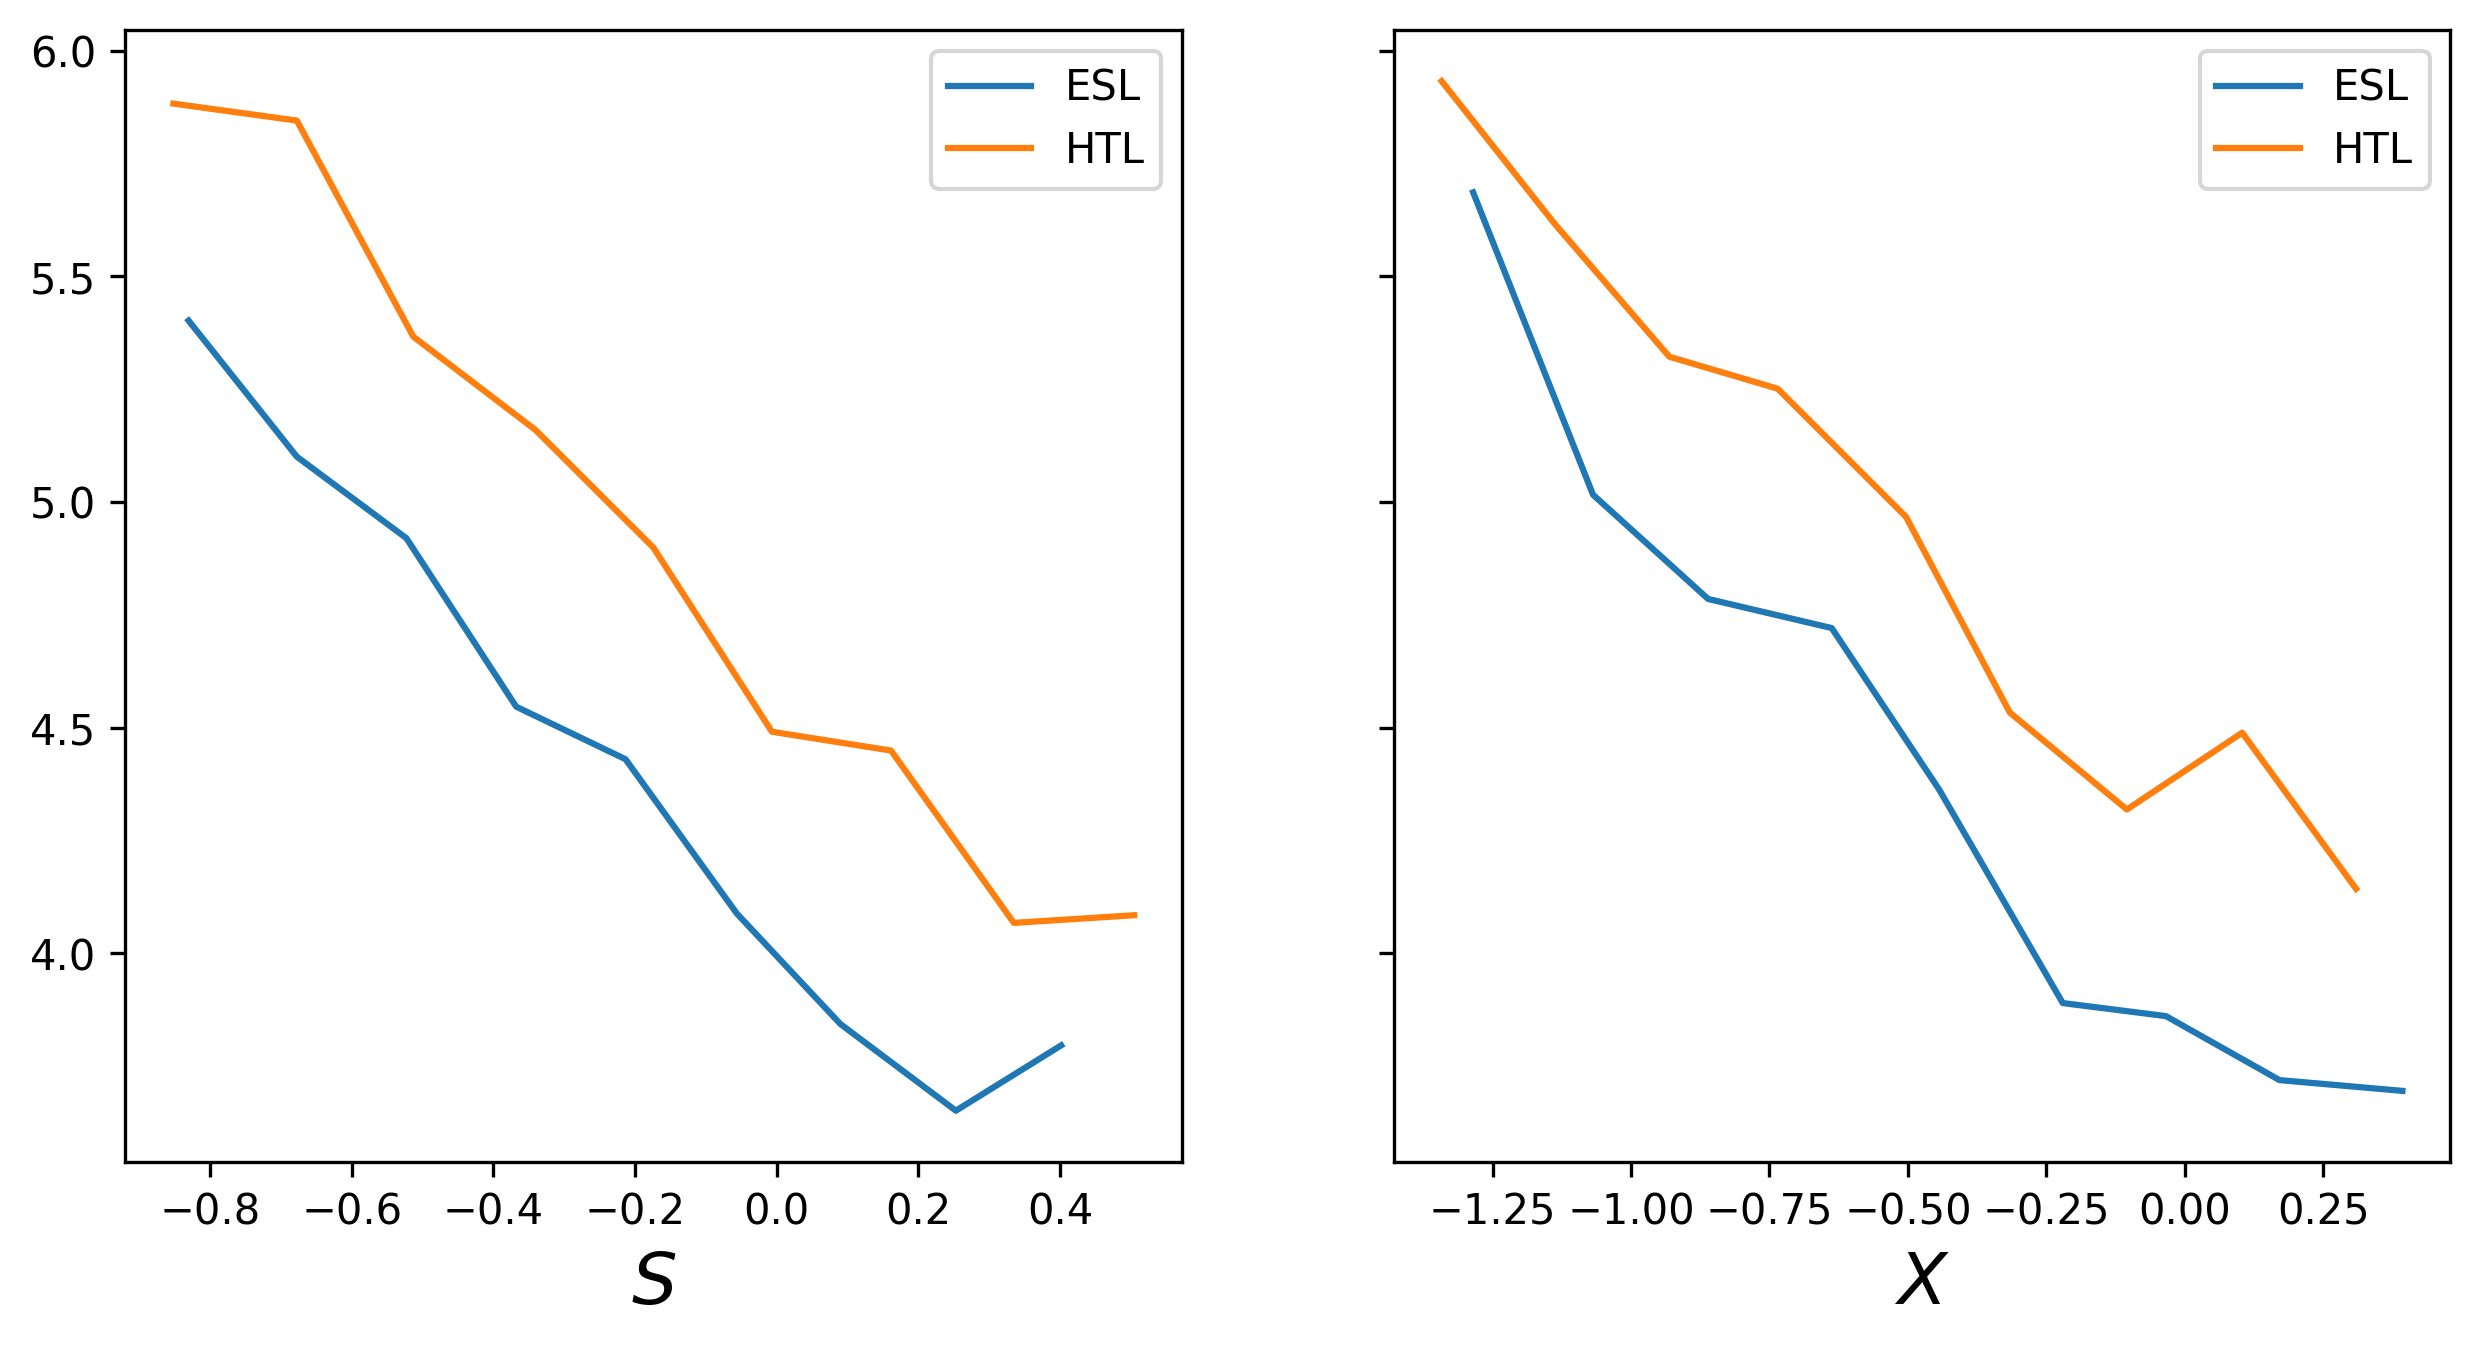

In [117]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), dpi=150, sharey=True)

nbins = 10

plt.sca(axs[0])
# sns.regplot(x=output["soft"], y=strain, x_bins=bins, label="ESL")
# sns.regplot(x=htl_output["soft"], y=htl_strain, x_bins=bins, label="HTL")
# cut into bins and plot
tdf = pd.DataFrame({"soft": output["soft"], "strain": stress})
q0 = tdf["soft"].quantile(0.1)
q1 = tdf["soft"].quantile(0.9)
bins = np.linspace(q0, q1, nbins)
tdf["bin"] = pd.cut(tdf["soft"], bins=bins)
tdf = tdf.groupby("bin").mean()
plt.plot(tdf["soft"], tdf["strain"], label="ESL")

tdf = pd.DataFrame({"soft": htl_output["soft"], "strain": htl_stress})
q0 = tdf["soft"].quantile(0.1)
q1 = tdf["soft"].quantile(0.9)
bins = np.linspace(q0, q1, nbins)
tdf["bin"] = pd.cut(tdf["soft"], bins=bins)
tdf = tdf.groupby("bin").mean()
plt.plot(tdf["soft"], tdf["strain"], label="HTL")
plt.legend()
plt.xlabel(r"$S$", size="xx-large")
# plt.ylabel(r"$\gamma^Y$", size="xx-large")

plt.sca(axs[1])
# sns.regplot(x=logit(zoft["out"][::10]), y=strain, x_bins=bins, label="ESL")
# sns.regplot(x=logit(zoft["out_htl"][::10]), y=htl_strain, x_bins=bins,
# label="HTL")
tdf = pd.DataFrame({"soft": logit(zoft["out"][::10].reshape(-1)), "strain": stress})
q0 = tdf["soft"].quantile(0.1)
q1 = tdf["soft"].quantile(0.9)
bins = np.linspace(q0, q1, nbins)
tdf["bin"] = pd.cut(tdf["soft"], bins=bins)
tdf = tdf.groupby("bin").mean()
plt.plot(tdf["soft"], tdf["strain"], label="ESL")

tdf = pd.DataFrame({"soft": logit(zoft["out_htl"][::10].reshape(-1)), "strain": htl_stress})
q0 = tdf["soft"].quantile(0.1)
q1 = tdf["soft"].quantile(0.9)
bins = np.linspace(q0, q1, nbins)
tdf["bin"] = pd.cut(tdf["soft"], bins=bins)
tdf = tdf.groupby("bin").mean()
plt.plot(tdf["soft"], tdf["strain"], label="HTL")
plt.legend()
plt.xlabel(r"$X$", size="xx-large")
# plt.ylabel(r"$\gamma^Y$", size="xx-large")